In [9]:
# Import packages

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import glob
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
import radlib
import os
import h5py
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
from cartopy.feature import NaturalEarthFeature
import xmltodict, geopandas, geojson, xml #xml and json do not exist
from datetime import datetime, timedelta
import geopy.distance
from datetime import datetime, timedelta
import numpy.matlib as npm
import copy
from scipy.signal import convolve2d
from astropy.convolution import convolve
import scipy.ndimage as ndi
import re
from skimage.draw import polygon

os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch



## Definitions

In [10]:
# Defining valid time and elevation scan

valid_time3 = '0650'
elevation_scan = '3'
radar_station = 'W'
radar_name = 'Weissfluhgipfel'

In [11]:
# Data Imports, processing, norming, etc.

# Transform function for dealiased velocity
def transform_from_digital(mydata, nyquist):
    myfinaldata = (mydata * 1.0 - 128) * nyquist / 127
    myfinaldata[mydata == 0] = np.nan
    return myfinaldata

# Convert polar coordinates (range, azimuth) to geographic coordinates (lat/lon)
def radar_to_latlon(radar_lat, radar_lon, ranges, azimuths):
    R = 6371.0  # Earth radius in kilometers
    azimuths_rad = np.radians(azimuths)
    latitudes = np.zeros((len(azimuths), len(ranges)))
    longitudes = np.zeros((len(azimuths), len(ranges)))

    for i, az in enumerate(azimuths_rad):
        latitudes[i, :] = radar_lat + (ranges / R) * np.cos(az) * (180.0 / np.pi)
        longitudes[i, :] = radar_lon + (ranges / R) * np.sin(az) * (180.0 / np.pi) / np.cos(np.radians(radar_lat))

    return latitudes, longitudes

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data=pd.read_csv(file).iloc[8:]
        headers=pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df=pd.DataFrame()
        for n in range(len(data)):
            t=data.iloc[n].str.split(';',expand=True)
            trt_df.loc[n,'traj_ID']=int(t[0].values)
            trt_df.loc[n,'time']=int(t[1].values)
            trt_df.loc[n,'lon']=t[2].values.astype(float)
            trt_df.loc[n,'lat']=t[3].values.astype(float)
            chx,chy=c_transform([trt_df.loc[n,'lon']],[trt_df.loc[n,'lat']])
            ix=np.round((chx-o_x)/1000).astype(int)
            if ix>=710: ix=709
            iy=np.round((chy-o_y)/1000).astype(int)
            if iy>=640: iy=639
            n2=27
            if int(ttime)>=221520631: n2=82
            tt=np.array(t)[0,n2:-1]
            tt=np.reshape(tt,[int(len(tt)/2),2])
            trt_df.loc[n,'chx']=chx
            trt_df.loc[n,'chy']=chy
            lat=tt[:,1].astype(float); lon=tt[:,0].astype(float)
            # trt_df=trt_df.astype(str)
            chx,chy=c_transform(lon,lat)
            ix=np.round((chx-o_x)/1000).astype(int)
            iy=np.round((chy-o_y)/1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr,cc]=int(t[0].values);
    # print(np.nanmax(cells))
    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define VAD reading function
def read_VAD(file_VAD):
    mydoc = xml.dom.minidom.parse(file_VAD)

    levels = mydoc.getElementsByTagName('level')
   
    heights = mydoc.getElementsByTagName('height')
    speeds = mydoc.getElementsByTagName('speed')
    directions = mydoc.getElementsByTagName('direction')
   
    vad_levels=np.zeros(len(levels))
    vad_heights=np.zeros(len(levels))
    vad_speeds=np.zeros(len(levels))
    vad_directions=np.zeros(len(levels))
    for m in range(0,len(levels)):
        vad_levels[m]=levels[m].firstChild.data
        vad_heights[m]=heights[m].firstChild.data
        vad_speeds[m]=speeds[m].firstChild.data
        vad_directions[m]=directions[m].firstChild.data
    vad_s=np.zeros(150); vad_d=np.zeros(150); vad_s[:]=np.nan; vad_d[:]=np.nan;
    for n in range(0,150):
        for m in range(0,len(levels)):
            if vad_levels[m]==n:
                vad_s[n]=vad_speeds[m]
                vad_d[n]=vad_directions[m]
       
       
    vad_u = np.multiply(vad_s, np.cos(np.radians(vad_d)))
    vad_v = np.multiply(vad_s, np.sin(np.radians(vad_d)))
   
    vadu=np.zeros(15); vadv=np.zeros(15);
    for n in range(0,15):
        a=n*10
        vadu[n]=np.nanmean(vad_u[a:a+10])
        vadv[n]=np.nanmean(vad_v[a:a+10])
       
    return vadu, vad_u, vadv, vad_v

# Function to calculate azimuth angle from radar to downburst location
def calculate_azimuth(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Calculate azimuth
    delta_lon = lon2 - lon1
    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
    azimuth = math.atan2(x, y)
    azimuth_deg = math.degrees(azimuth)
    
    # Normalize to 0-360 degrees
    return (azimuth_deg + 360) % 360

# Convolves and normalizes 2D data with a 3x3 kernel
def conv(data):
    """
    Convolves and normalizes 2D data with a 3x3 kernel

    Parameters
    ----------
    data : 2-D array
        data to be convolved.

    Returns
    -------
    d_conv : 2-D array
        convolved data.

    """
    ## convolves 2D data with a 3x3 kernel, equal weights, wrapped boundary, NaN values ignored / filled in
    g_kernel=np.ones([3,3])/9
    d_conv=convolve(data,g_kernel, boundary='wrap')
    return d_conv

# azimuthal centered difference derivative for polar data -> wraps around 0/360
def az_cd(myfinaldata, nyquist, threshold, resolution, min_size):
    """
    azimuthal centered difference derivative for polar data -> wraps around 0/360

    Parameters
    ----------
    myfinaldata : 2D array
        input data.
    nyquist : float
        Nyquist velocity of raw velocity data.
    threshold : float
        shear correction threshold.
    resolution : float
        radial resolution of data.
    min_size : int
        minimum number of gates required for correction.

    Returns
    -------
    myshear_cor : 2D array
        azimuthal derivative, corrected for unfolding errors.
    mygateshear_cor : 2D array
        azimuthal difference (no normalization by distance), corrected for unfolding errors.

    """
    ## azimuthal derivative, centered difference
    ## corrects for anomalous shear exceeding threshold
    ## shear only corrected if contiguous area of several pixels
    myfinaldata_1=np.zeros(myfinaldata.shape)
    myfinaldata_1[:-1,:]=myfinaldata[1:,:]
    myfinaldata_1[-1,:]=myfinaldata[0,:]
    myfinaldata_2=np.zeros(myfinaldata.shape)
    myfinaldata_2[1:,:]=myfinaldata[:-1,:]
    myfinaldata_2[0,:]=myfinaldata[-1,:]
    
    distance=np.arange(0.5*resolution, myfinaldata.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,myfinaldata.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)
    
    myshear_1=(myfinaldata-myfinaldata_1)/(2*distance)*-(1)
    myshear_2=(myfinaldata_2-myfinaldata)/(2*distance)*(-1)
    myshear_3=(myfinaldata_2-myfinaldata_1)/(2*distance)*(-1)
    
    myshear_1_cor=shear_cor(myshear_1, distance, threshold, nyquist, min_size)
        
    myshear_2_cor=shear_cor(myshear_2, distance, threshold, nyquist, min_size)

    myshear_3_cor=shear_cor(myshear_3, distance, threshold, nyquist, min_size)
    
    myshear_cor=np.nansum([myshear_2_cor,myshear_1_cor],axis=0)
    myshear_cor[np.isnan(myfinaldata)==1]=myshear_3_cor[np.isnan(myfinaldata)==1]
    mygateshear_cor=myshear_cor*distance
    
    return myshear_cor, mygateshear_cor

# Identifies unfolding errors in derivative and corrects for them
def shear_cor(myshear, distance, threshold, nyquist, min_size):
    """
    Identifies unfolding errors in derivative and corrects for them

    Parameters
    ----------
    myshear : 2D array
        input data.
    distance : 2D array
        azimuthal Cartesian distance between gates.
    threshold : float
        error identification threshold.
    nyquist : float
        correction interval (nyquist velocity).
    min_size : int
        minimum number of connected erroneous gates.

    Returns
    -------
    myshear_cor : 2D array
        corrected data.

    """
    ## function embedded in centered difference shear
    ## eliminates anomalous shear in contiguous area
    myshear_cor=(myshear*(2*distance))
    thresh_1=(myshear*(2*distance))-threshold
    thresh_2=(myshear*(2*distance))+threshold
    
    mybin_pos=np.zeros(myshear.shape)
    mybin_pos[thresh_1>=0]=1
    labels, n_groups=ndi.label(mybin_pos)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] -= (2*nyquist)
    
    mybin_neg=np.zeros(myshear.shape)
    mybin_neg[thresh_2<=0]=1
    labels, n_groups=ndi.label(mybin_neg)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] += (2*nyquist)
    myshear_cor=myshear_cor/(2*distance)
    return myshear_cor

# azimuthal linear least squares derivative        
def az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    azimuthal linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    az_shear : array of same dimensions as data
        azimuthal derivative of data.

    """
    ##azimuthal linear least squares derivative
    az_shear=( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k_thet * ( - np.sum(weights * d_r * d_r) * np.sum(weights) + np.sum(weights * d_r) * np.sum(weights * d_r)) \
                + u_k * (np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) - np.sum(weights * d_r) * np.sum(weights * d_r * d_theta)) )
    return az_shear

# radial linear least squares derivative
def div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    radial linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    div_shear : array of same dimensions as data
        radial derivative of data.

    """
    ##radial linear least squares derivative
    div_shear= ( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (- np.sum(weights * d_theta * d_theta) * np.sum(weights) + np.sum(weights * d_theta) * np.sum(weights * d_theta)) \
                + u_k_thet * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k * ( - np.sum(weights * d_r * d_theta) * np.sum(weights * d_theta) + np.sum(weights * d_r) * np.sum(weights * d_theta * d_theta)) )
    return div_shear

# full linear least squares derivative
def llsd(vel, az_min, az_max, w_k, r_k, resolution):
    """
    full linear least squares derivative

    Parameters
    ----------
    vel : 2D array
        input data, polar data.
    az_min : int
        min. number of gates in azimuth.
    az_max : int
        max. number of gates in azimuth.
    w_k : float
        kernel width in azimuth (Cartesian).
    r_k : float
        kernel width in radial (Cartesian).
    resolution : float
        radial resolution.

    Returns
    -------
    az_shear : 2D array
        azimuthal derivative.
    div_shear : 2D array
        radial derivative.

    """
    ##complete linear least squares derivative
    az_shear=np.zeros(vel.shape); az_shear[:]=np.nan
    div_shear=np.zeros(vel.shape); div_shear[:]=np.nan
    
    distance=np.arange(0.5*resolution, vel.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,vel.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)

    r_h=int(np.floor(az_max/2))
	
    for n2 in range(r_h,vel.shape[1]-r_h):
        
        az_w=int(np.round(w_k/distance[1,n2]));
        if az_w%2 == 0: az_w+=1
        if az_w>az_max: az_w=az_max
        if az_w<az_min: az_w=az_min
        az_r=int(np.floor(az_w/2))
        
        r_w= r_k/resolution;
        if r_w%2 == 0: r_w+=1
        r_w=int(r_w)
        r_r=r_w*resolution
        r_vec=np.arange(-r_r,r_r+resolution,resolution)
        r_vec=np.expand_dims(r_vec,axis=0)
        d_r=np.repeat(r_vec,az_w,axis=0)
        
        d_r=np.zeros([az_w,r_w])
        for n2_2 in range(0,r_w):
            d_r[:,n2_2]=-r_k*n2_2/(r_w-1)+r_k*0.5
        rw_f=int(np.floor(r_w/2))
	    
        d_r2=-copy.deepcopy(d_r); #print(d_r.shape,n2)
        weights=np.ones([az_w,r_w])
        d_theta=copy.deepcopy(distance[:az_w,n2-rw_f:n2+rw_f+1]); d_theta[az_r,:]=0
        d_theta[:az_r,:]=-d_theta[:az_r,:];
        d_thet=copy.deepcopy(d_theta); d_thet=-np.flip(d_thet,1)

        u_k=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],weights,mode='same',boundary='wrap')[:,1]
        u_k_thet=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_thet,mode='same',boundary='wrap')[:,1]
        u_k_r=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_r2,mode='same',boundary='wrap')[:,1]

        az_shear[:,n2]= az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
        div_shear[:,n2]= div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
    return az_shear, div_shear

# c_transform
def c_transform(lon,lat):
    """
    transforms arrays of lat/lon to chx/chy

    Parameters
    ----------
    lon : float
        longitude.
    lat : float
        latitude.

    Returns
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.

    """
    converter = GPSConverter()
    chx=np.zeros([len(lon)])
    chy=np.zeros([len(lon)])
    for n in range(len(lon)):
        chx[n],chy[n],z=converter.WGS84toLV03(lat[n], lon[n], 0)
    return chx,chy

# transform_c 
def transform_c(chx,chy):
    """
    transforms arrays of chx/chy to lat/lon
    
    Parameters
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.
        
    Returns
    ----------
    lon : float
        longitude.
    lat : float
        latitude.



    """
    converter = GPSConverter()
    lon=np.zeros([len(chx)])
    lat=np.zeros([len(chy)])
    for n in range(len(lon)):
        lat[n], lon[n],z=converter.LV03toWGS84(chx[n],chy[n], 0)
    return lon,lat



# Radar location (Lema radar, Switzerland)
if radar_station=='L':
    radar_lat = 46.0401
    radar_lon = 8.8334
    radar_alt = 1627 
if radar_station=='P':
    radar_lat = 46.37083
    radar_lon = 7.48694
    radar_alt = 2927
if radar_station=='W':
    radar_lat = 46.832
    radar_lon = 9.796
    radar_alt = 2892 

# Coordinates of cities
locarno_lat = 46.1700
locarno_lon = 8.7996
lugano_lat = 46.0037
lugano_lon = 8.9511

# Load radar data
path = '/scratch/mch/fackerma/orders/case_130721'

file = glob.glob(path + '/MLL/ML' + radar_station + '21194' + valid_time3 + '0U.00' + elevation_scan)
file2 = glob.glob(path +'/DVL/srn/data/tmp/mof/DV' + radar_station + '/DV' + radar_station +'21194' + valid_time3 + '7L.80' + elevation_scan) # Dealiased velocity
file3 = glob.glob(path +'/HZC/HZC21194' + valid_time3 + 'VL.801') # Freezing level height composite
file4 = glob.glob(path +'/VAL/VA' + radar_station + '21194' + valid_time3 + '7U.019') # Vertical wind profile above radar
file5 = glob.glob(path +'/BZC/BZC21194' + valid_time3 + 'VL.845') # POH
file6 = glob.glob(path +'/MZC/MZC21194' + valid_time3 + 'VL.850') # MESH
file7 = glob.glob(path +'/TRTC/CZC21194' + valid_time3 + '0T.rdt') # Thunderstorm radar tracking; or .rdt .trt
file8 = glob.glob(path +'/CZC/CZC21194' + valid_time3 + 'VL.801') # Reflectivity composite
file9 = glob.glob(path +'/LZC/LZC21194' + valid_time3 + 'VL.801') # VIL composite
file10 = glob.glob(path +'/EZC/EZC21194' + valid_time3 + 'VL.820') # Echotops composite: 815, 820, 845, 850
file11 = glob.glob(path +'/OZC/OZC21194' + valid_time3 + 'VL.830') # CAPPI composite, ranging from 810 to 980 in steps of 10
file12 = glob.glob(path + '/dARC/ARC211940000FF.1440') # daily bias corrected rain accumulation
file13 = glob.glob(path + '/dBZC/BZC211942400VL.845') # daily POH
file14 = glob.glob(path + '/dRZC/RZC211942400VL.801') # daily Rain Rate
file15 = glob.glob(path + '/dCZC/CZC211942400VL.801') # daily Max Echo


# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data

dv_data = pyart.aux_io.read_file_py(file2[0], physic_value=False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq = float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)

hzc_data = radlib.read_file(file3[0],physic_value=True)
hzc=hzc_data.data

dARC_data = radlib.read_file(file12[0],physic_value=True)
dARC=dARC_data.data

dBZC_data = radlib.read_file(file13[0],physic_value=True)
dBZC=dBZC_data.data

dRZC_data = radlib.read_file(file14[0],physic_value=True)
dRZC=dRZC_data.data

dCZC_data = radlib.read_file(file15[0],physic_value=True)
dCZC=dCZC_data.data

diff_reflectivity = data.get_field(0, 'differential_reflectivity').data

diff_phase = data.get_field(0, 'uncorrected_differential_phase').data

cc_ratio = data.get_field(0, 'uncorrected_cross_correlation_ratio').data

mzc_data = radlib.read_file(file6[0],physic_value=True)
mzc=mzc_data.data

bzc_data = radlib.read_file(file5[0],physic_value=True)
bzc=bzc_data.data

specw = data.get_field(0, 'spectrum_width').data

czc_data = radlib.read_file(file8[0],physic_value=True)
czc=czc_data.data

lzc_data = radlib.read_file(file9[0],physic_value=True)
lzc=lzc_data.data

ezc_data = radlib.read_file(file10[0],physic_value=True)
ezc=ezc_data.data

ozc_data = radlib.read_file(file11[0],physic_value=True)
ozc=ozc_data.data

path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_130721/"}  # Replace with your actual path
trtc = read_TRT(path_trtc, ttime=valid_time3)

vad = read_VAD(file4[0])

# Convert echotop18 from km to meters
ezc_m = ezc * 1000
# Compute the wind gust estimator 'wge' (Trefalt 2017)
wge = np.sqrt((-3.1 * 10**-6 * (ezc**2)) + (20.6 * lzc))


resolution = 0.5
range_max = reflectivity.shape[1] * resolution
azimuths = np.linspace(0, 360, reflectivity.shape[0])
ranges = np.arange(0, range_max, resolution)

# Kdp own method
smoothed_diff_phase = gaussian_filter1d(diff_phase, sigma=2, axis=1) 
Kdp = np.gradient(smoothed_diff_phase, ranges, axis=1)

# KDP Vulpiani Method
#Kdp = pyart.retrieve.kdp_vulpiani(data, psidp_field='uncorrected_differential_phase', band='C', parallel=True)

llsd_vel = llsd(vel=dv_velocity, az_min=3, az_max=90, w_k=2, r_k=1.5, resolution=0.5)




# Transform radar polar coordinates to lat/lon
lats, lons = radar_to_latlon(radar_lat, radar_lon, ranges, azimuths)

# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)
# Initialize transformer for Swiss grid 
transformer = Transformer.from_crs(21781, 3035, always_xy=True)

#lons,lats = transformer.transform(X, Y)
clons, clats = transformer.transform(X, Y)
#lons, lats = transformer.transform(X, Y)


# Define color steps for Reflectivity and Velocity/Dealiased Velocity
czc_levels = np.arange(-5, 65, 5)  # Steps of 2 for Reflectivity
reflectivity_levels = np.arange(-5, 65, 5)  # Steps of 2 for Reflectivity
velocity_levels = np.arange(-25, 26, 5)  # Steps of 1 for Velocity and Dealiased Velocity
hzc_levels = np.arange(1, 10, 1)
diff_reflectivity_levels = np.arange(-7,9,2)
diff_phase_levels = np.arange(-70,90,20)
cc_ratio_levels = np.arange(0.7,1,0.05)
mzc_levels = np.arange(0,5.5,0.5)
bzc_levels = np.arange(0,101,10)
specw_levels = np.arange(0,7,1)
Kdp_levels = np.arange(0,5.5,0.5)
lzc_levels = np.arange(2.5,25,2.5)
ezc_levels = np.arange(2,16,2)
wge_levels = np.arange(2,20,2)
az_shear_levels = np.arange(-10,12,2)
div_shear_levels = np.arange(-10,12,2)
# Create boundary norms
czc_norm = BoundaryNorm(boundaries=czc_levels, ncolors=plt.cm.inferno.N, clip=True)
reflectivity_norm = BoundaryNorm(boundaries=reflectivity_levels, ncolors=plt.cm.inferno.N, clip=True)
velocity_norm = BoundaryNorm(boundaries=velocity_levels, ncolors=256, clip=True)
hzc_norm = BoundaryNorm(boundaries=hzc_levels, ncolors=256, clip=True)
diff_reflectivity_norm = BoundaryNorm(boundaries=diff_reflectivity_levels, ncolors=256, clip=True)
diff_phase_norm = BoundaryNorm(boundaries=diff_phase_levels, ncolors=256, clip=True)
cc_ratio_norm = BoundaryNorm(boundaries=cc_ratio_levels, ncolors=256, clip=True)
mzc_norm = BoundaryNorm(boundaries=mzc_levels, ncolors=256, clip=True)
bzc_norm = BoundaryNorm(boundaries=bzc_levels, ncolors=256, clip=True)
specw_norm = BoundaryNorm(boundaries=specw_levels, ncolors=256, clip=True)
Kdp_norm = BoundaryNorm(boundaries=Kdp_levels, ncolors=256, clip=True)
lzc_norm = BoundaryNorm(boundaries=lzc_levels, ncolors=256, clip=True)
ezc_norm = BoundaryNorm(boundaries=ezc_levels, ncolors=256, clip=True)
wge_norm = BoundaryNorm(boundaries=wge_levels, ncolors=256, clip=True)
az_shear_norm = BoundaryNorm(boundaries=az_shear_levels, ncolors=256, clip=True)
div_shear_norm = BoundaryNorm(boundaries=div_shear_levels, ncolors=256, clip=True)

cmap_czc = plt.cm.inferno
cmap_velocity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"], N=256)
cmap_hzc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "dodgerblue", "midnightblue"], N=256)
cmap_diff_reflectivity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_phase = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_cc_ratio = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_Kdp = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_bzc = LinearSegmentedColormap.from_list("custom_cmap", ["black","yellow", "red"], N=256)
cmap_specw = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_lzc = LinearSegmentedColormap.from_list("custom_cmap", ["black", "cyan", "purple"], N=256)
cmap_ezc = plt.cm.Blues
cmap_wge = plt.cm.magma
cmap_vad = plt.cm.Accent
cmap_az_shear = LinearSegmentedColormap.from_list("custom_cmap", ["aqua","blue", "black", "red","yellow"], N=256)
cmap_div_shear = cmap_az_shear

# Assess rhi files
files_rhi = sorted(glob.glob(path + '/MLL/MLL21194' + valid_time3 + '*')) # Read all elevations for rhi
for i,f in enumerate(files_rhi):
    radar = pyart.aux_io.read_metranet(f)
    
    if i == 0:
        radar_merged = radar
    else:
        radar_merged = pyart.util.join_radar(radar_merged, 
                                       radar)
#corr_vel = pyart.correct.dealias_region_based(radar_merged)
#radar_merged.add_field('corrected_velocity', corr_vel)





class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
                - (0.270978 * pow(y_aux, 2)) + \
                - (0.002528 * pow(x_aux, 2)) + \
                - (0.0447 * pow(y_aux, 2) * x_aux) + \
                - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
                + (0.791484 * y_aux * x_aux) + \
                + (0.1306 * y_aux * pow(x_aux, 2))) + \
                - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)
		
    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0 
        minute = 0 
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)
    
    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
            + (3745.25 * pow(lng_aux, 2)) + \
            + (76.63 * pow(lat_aux,2))) + \
            - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

	# Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d
        
    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d
        
if __name__ == "__main__":
    ''' Example usage for the GPSConverter class.'''

    converter = GPSConverter()

    # Coordinates
    wgs84 = []
    lv03  = [567719, 155077, 1974]
    #567719/ 155077  Altitude: 1974
    # Convert WGS84 to LV03 coordinates
    wgs84 = converter.LV03toWGS84(lv03[0], lv03[1], lv03[2])

    print("WGS84: ")
    print(wgs84)
    print("LV03: ")
    print(lv03)



py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
swap product table data ......
py_decoder DBG verb=0
py_decoder DBG verbl=0


/tmp/ipykernel_217559/1033505506.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers=pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_217559/1033505506.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n,'traj_ID']=int(t[0].values)
/tmp/ipykernel_217559/1033505506.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n,'time']=int(t[1].values)
/tmp/ipykernel_217559/1033505506.py:111: DeprecationWarning: Conve

WGS84: 
[46.54620053012867, 7.017760746224894, 2024.97379732]
LV03: 
[567719, 155077, 1974]


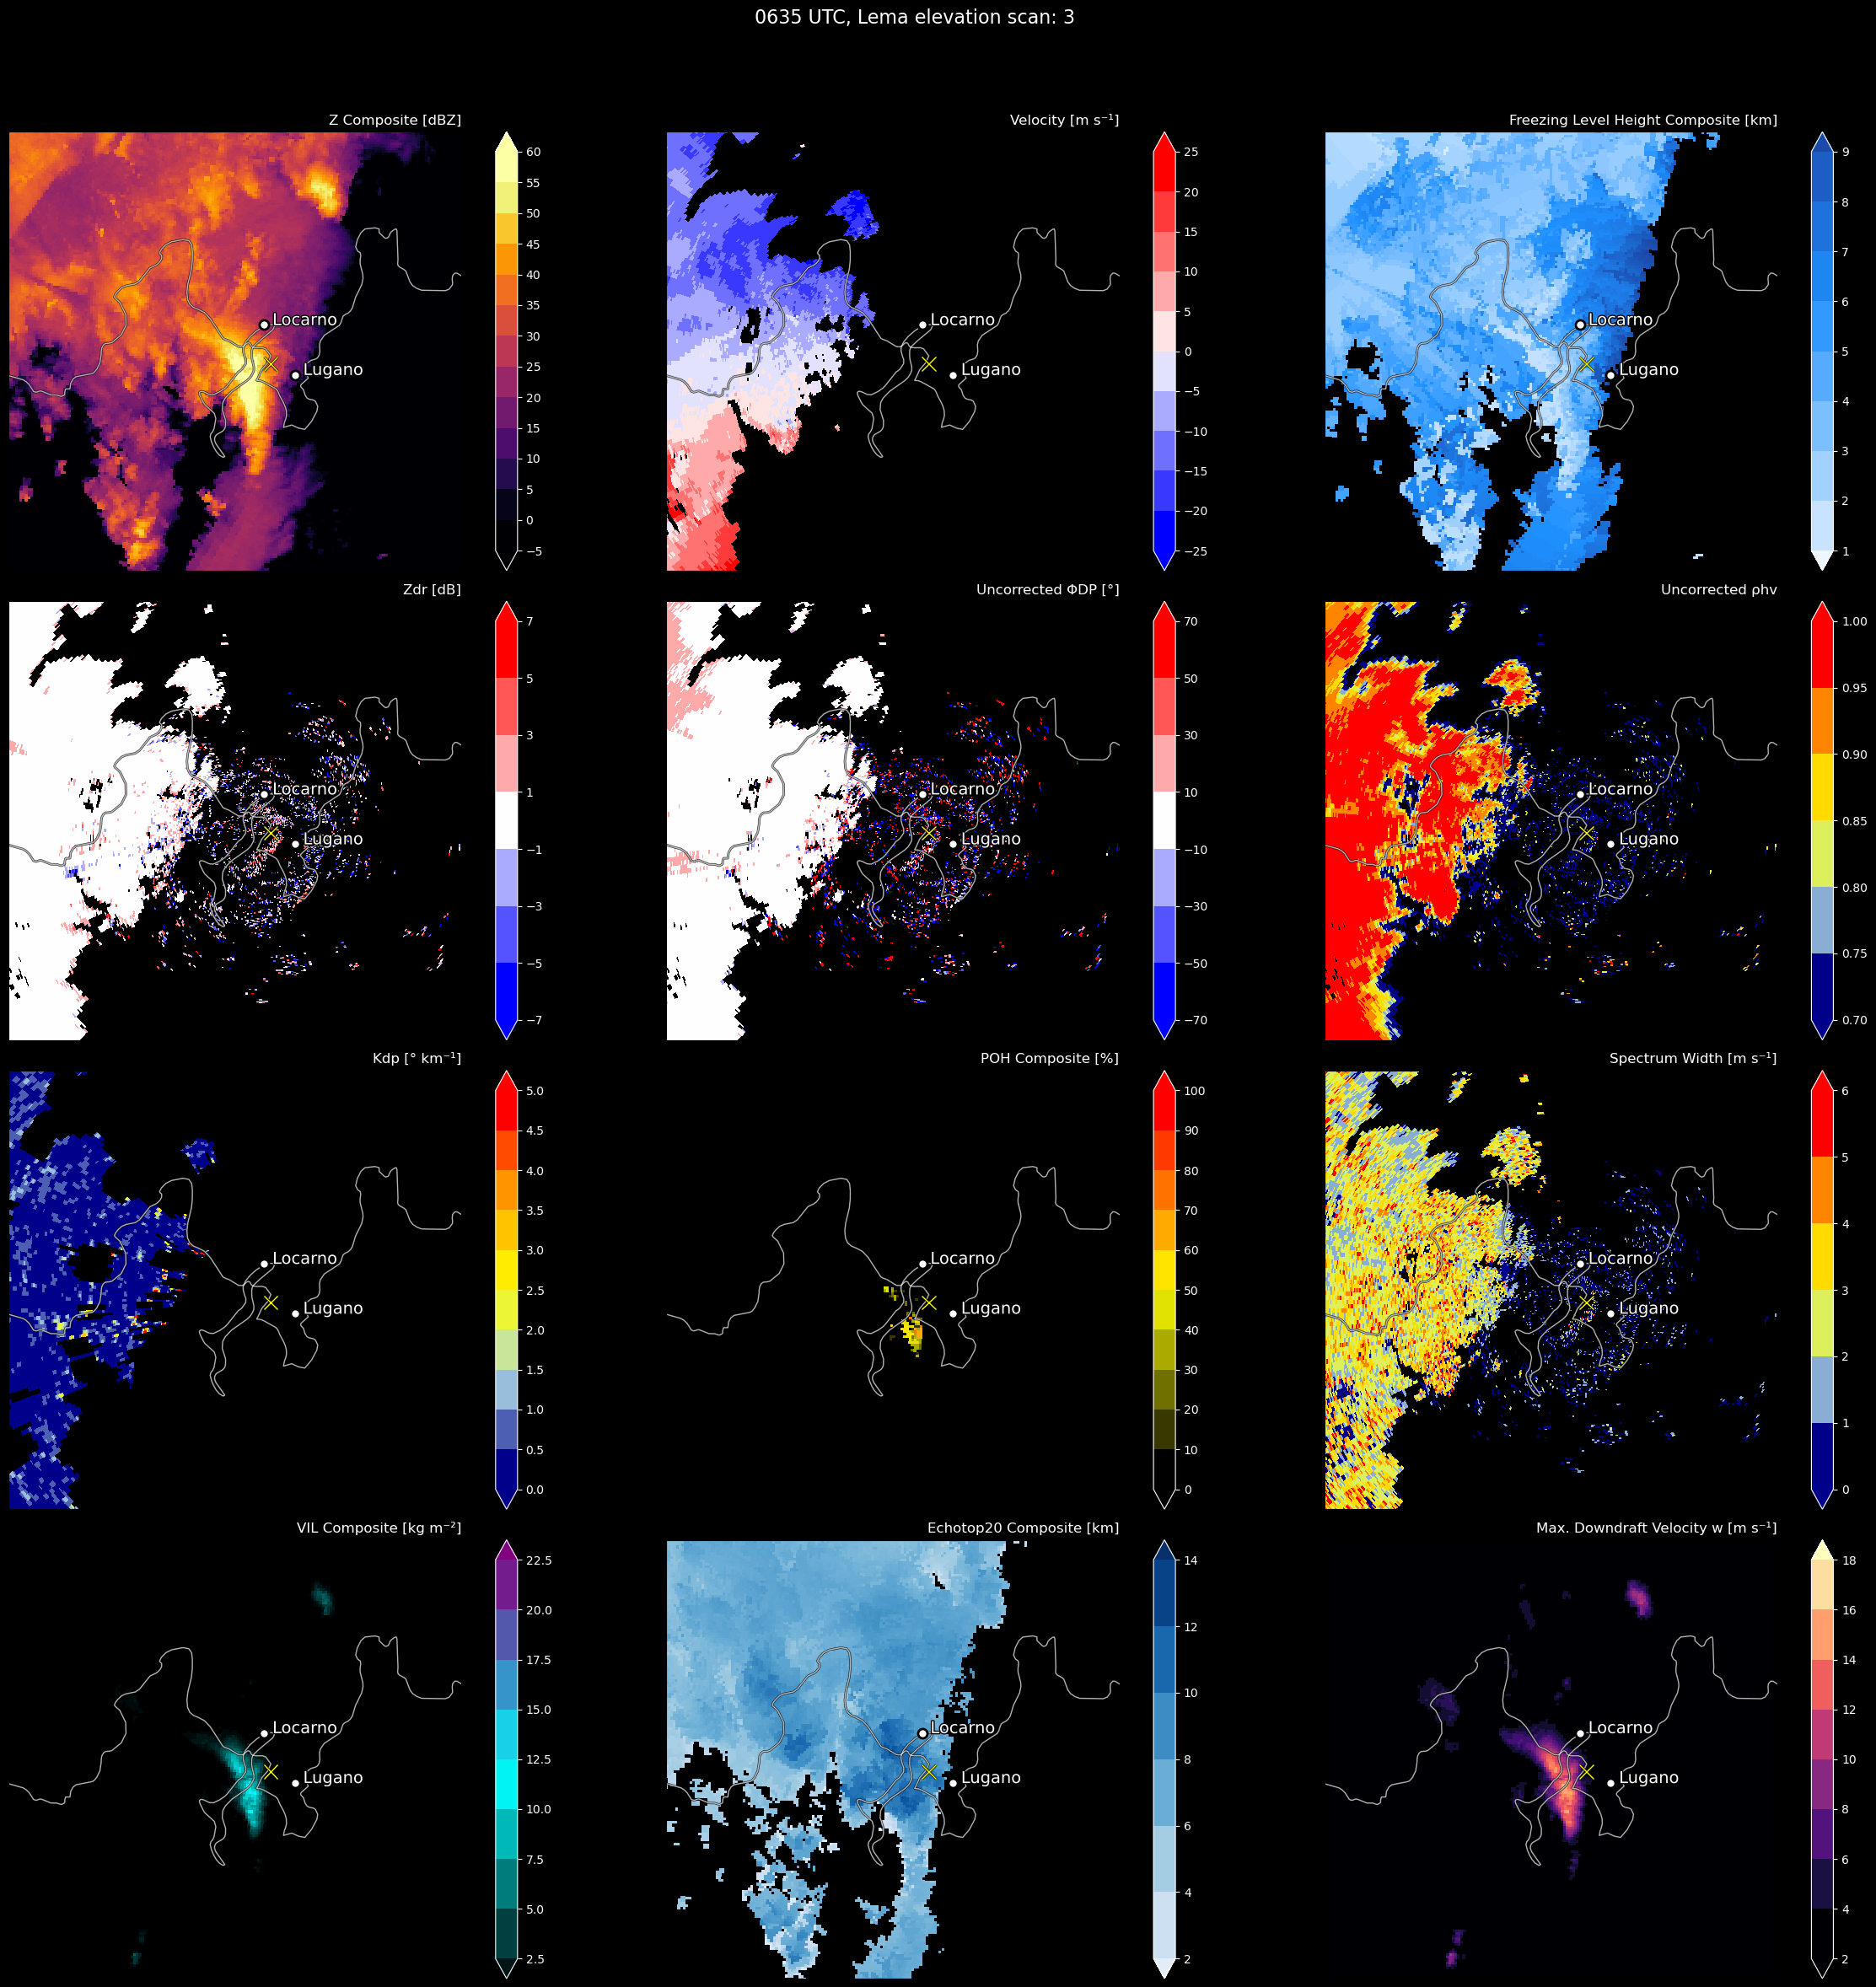

In [13]:
# Multi-variable plot
projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24,24), subplot_kw={'projection': projection})

# Set background to black for all subplots
for row in axs:  # axs is a 2D array, so iterate through rows
    for ax in row:  # Iterate through each subplot in the row
        fig.patch.set_facecolor('black')  # Set figure background
        ax.set_facecolor('black')  # Set axis background



# Plot Reflectivity composite
cmap_czc = plt.cm.inferno
cmap_czc.set_bad(color='grey')
p1 = axs[0,0].pcolormesh(clons, clats, czc, vmin=0, vmax=55, 
                   cmap=cmap_czc, transform=projection)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=axs[0,0], extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor('white')
cbar1.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')
axs[0,0].set_title('Z Composite [dBZ]', color='white', loc='right')


# Plot Dealiased Velocity
cmap_velocity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"], N=256)
cmap_velocity.set_bad(color='black')
# Assuming lons and lats are 1D arrays
p2 = axs[0,1].pcolormesh(lons, lats, dv_velocity, cmap=cmap_velocity, norm=velocity_norm, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(p2, ax=axs[0,1], cmap=cmap_velocity, extend='both', boundaries=velocity_levels, ticks=velocity_levels)
cbar2.outline.set_edgecolor('white')
cbar2.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')
axs[0,1].set_title('Velocity [m s⁻¹]', color='white', loc='right')


# Plot Freezing level height
# Mask values of freezing level height that are 0 or lower
hzc_masked = np.ma.masked_less_equal(hzc, 0)
# Define a custom colormap, setting the under value (for masked/low values) to black
cmap_hzc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "dodgerblue", "midnightblue"], N=256)
#cmap_hzc.set_under('black')  # Black for values 0 or lower
cmap_hzc.set_bad(color='black')  # Black for invalid data
# Plot the freezing level height with the masked values
p3 = axs[0,2].pcolormesh(clons, clats, hzc_masked, vmin=0, vmax=12, 
                         cmap=cmap_hzc, transform=projection)
# Add a colorbar
cbar3 = plt.colorbar(p3, ax=axs[0,2], extend='both', cmap=cmap_hzc, boundaries=hzc_levels, ticks=hzc_levels)
cbar3.outline.set_edgecolor('white')
cbar3.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar3.ax.axes, 'yticklabels'), color='white')
axs[0,2].set_title('Freezing Level Height Composite [km]', color='white', loc='right')


# Plot Differential Reflectivity
cmap_diff_reflectivity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_reflectivity.set_bad(color='black')
p4 = axs[1,0].pcolormesh(lons, lats, diff_reflectivity, cmap=cmap_diff_reflectivity, norm=diff_reflectivity_norm, 
                         transform=ccrs.PlateCarree())
cbar4 = plt.colorbar(p4, ax=axs[1,0], cmap=cmap_diff_reflectivity, extend='both', boundaries=diff_reflectivity_levels, ticks=diff_reflectivity_levels
                     )
cbar4.outline.set_edgecolor('white')
cbar4.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar4.ax.axes, 'yticklabels'), color='white')
axs[1,0].set_title('Zdr [dB]', color='white', loc='right')


# Plot Differential Phase
cmap_diff_phase = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_phase.set_bad(color='black')
p5 = axs[1,1].pcolormesh(lons, lats, diff_phase, cmap=cmap_diff_phase, norm=diff_phase_norm, 
                         transform=ccrs.PlateCarree())
cbar5 = plt.colorbar(p5, ax=axs[1,1], cmap=cmap_diff_phase, extend='both', boundaries=diff_phase_levels, ticks=diff_phase_levels
                     )
cbar5.outline.set_edgecolor('white')
cbar5.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar5.ax.axes, 'yticklabels'), color='white')
axs[1,1].set_title('Uncorrected ΦDP [°]', color='white', loc='right')


# Plot CC ratio
cmap_cc_ratio = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_cc_ratio.set_bad(color='black')
p6 = axs[1,2].pcolormesh(lons, lats, cc_ratio, cmap=cmap_cc_ratio, norm=cc_ratio_norm, 
                         transform=ccrs.PlateCarree())
cbar6 = plt.colorbar(p6, ax=axs[1,2], cmap=cmap_cc_ratio, extend='both', boundaries=cc_ratio_levels, ticks=cc_ratio_levels
                     )
cbar6.outline.set_edgecolor('white')
cbar6.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar6.ax.axes, 'yticklabels'), color='white')
axs[1,2].set_title('Uncorrected ρhv', color='white', loc='right')


# Plot Kdp
cmap_Kdp = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_Kdp.set_bad(color='black')
p7 = axs[2,0].pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=axs[2,0], extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor('white')
cbar7.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color='white')
axs[2,0].set_title('Kdp [° km⁻¹]', color='white', loc='right')


# Plot POH
cmap_bzc = LinearSegmentedColormap.from_list("custom_cmap", ["black","yellow", "red"], N=256)
cmap_bzc.set_bad(color='black')
p8 = axs[2,1].pcolormesh(clons, clats, bzc, norm=bzc_norm,
                   cmap=cmap_bzc, transform=projection)
# Add a colorbar
cbar8 = plt.colorbar(p8, ax=axs[2,1], extend='both', cmap=cmap_bzc, boundaries=bzc_levels, ticks=bzc_levels
                     )
cbar8.outline.set_edgecolor('white')
cbar8.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar8.ax.axes, 'yticklabels'), color='white')
axs[2,1].set_title('POH Composite [%]', color='white', loc='right')


# Plot Spectrum Width
cmap_specw = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_specw.set_bad(color='black')
p9 = axs[2,2].pcolormesh(lons, lats, specw, cmap=cmap_specw, norm=specw_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[2,2], cmap=cmap_specw, extend='both', boundaries=specw_levels, ticks=specw_levels
                     )
cbar9.outline.set_edgecolor('white')
cbar9.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color='white')
axs[2,2].set_title('Spectrum Width [m s⁻¹]', color='white', loc='right')

# Plot VIL composite
#lzc = np.ma.masked_less_equal(lzc, 0.1)
cmap_lzc = LinearSegmentedColormap.from_list("custom_cmap", ["black", "cyan", "purple"#, "red"
                                                             ], N=256)
cmap_lzc.set_bad(color='black')
p10 = axs[3,0].pcolormesh(clons, clats, lzc, vmin=1, vmax=22.5, 
                   cmap=cmap_lzc, transform=projection)
# Add a colorbar
cbar10 = plt.colorbar(p10, ax=axs[3,0], extend='both', cmap=cmap_lzc, norm=lzc_norm, boundaries=lzc_levels, ticks=lzc_levels
                     )
cbar10.outline.set_edgecolor('white')
cbar10.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar10.ax.axes, 'yticklabels'), color='white')
axs[3,0].set_title('VIL Composite [kg m⁻²]', color='white', loc='right')

# Plot Echotop 20 composite
# Set a mask
ezc = np.ma.masked_less_equal(ezc, 0)
cmap_ezc = plt.cm.Blues
cmap_ezc.set_bad(color='black')
p11 = axs[3,1].pcolormesh(clons, clats, ezc, vmin=0, vmax=14,  
                   cmap=cmap_ezc, transform=projection)
# Add a colorbar
cbar11 = plt.colorbar(p11, ax=axs[3,1], extend='both', cmap=cmap_ezc, norm=ezc_norm, boundaries=ezc_levels, ticks=ezc_levels
                     )
cbar11.outline.set_edgecolor('white')
cbar11.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar11.ax.axes, 'yticklabels'), color='white')
axs[3,1].set_title('Echotop20 Composite [km]', color='white', loc='right')

# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge = plt.cm.magma
cmap_wge.set_bad(color='black')
p12 = axs[3,2].pcolormesh(clons, clats, wge, vmax=18, 
                   cmap=cmap_wge, transform=projection)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=axs[3,2], extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor('white')
cbar12.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color='white')
axs[3,2].set_title('Max. Downdraft Velocity w [m s⁻¹]', color='white', loc='right')

# (Plotting of wind barbs and other features remains the same)
# Add Radar, Geneva, and Lausanne locations to all plots
for row in axs:
    for ax in row:
            #ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree())  # Radar location
        ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
        ax.plot(locarno_lon, locarno_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())  # Geneva
        ax.plot(lugano_lon, lugano_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())  # Lausanne
        ax.set_extent([7.6, 9.75 , 45.35, 46.8], crs=ccrs.PlateCarree())
         # Add borders, coastlines, and lakes with custom contour lines
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        # Add city names with a black outline for visibility
        locarno_text = ax.text(locarno_lon + 0.04, locarno_lat, 'Locarno', color='white', fontsize=14, transform=ccrs.PlateCarree())
        lugano_text = ax.text(lugano_lon + 0.04, lugano_lat, 'Lugano', color='white', fontsize=14, transform=ccrs.PlateCarree())
        locarno_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        lugano_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

    



# Adjust margins and layout
#plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)
#plt.tight_layout(pad=2.0)

# Set main title
plt.suptitle(valid_time3 + ' UTC, Lema elevation scan: ' + elevation_scan #+ ', Barbs: 10 min mean surface wind [km h⁻¹]'
             , color='white', fontsize=16, x=0.5)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
#plt.savefig("/users/fackerma/newproject1/figures/second_case/" + valid_time3 + "_" + elevation_scan + "_all_variables.png", facecolor='black', dpi=300)

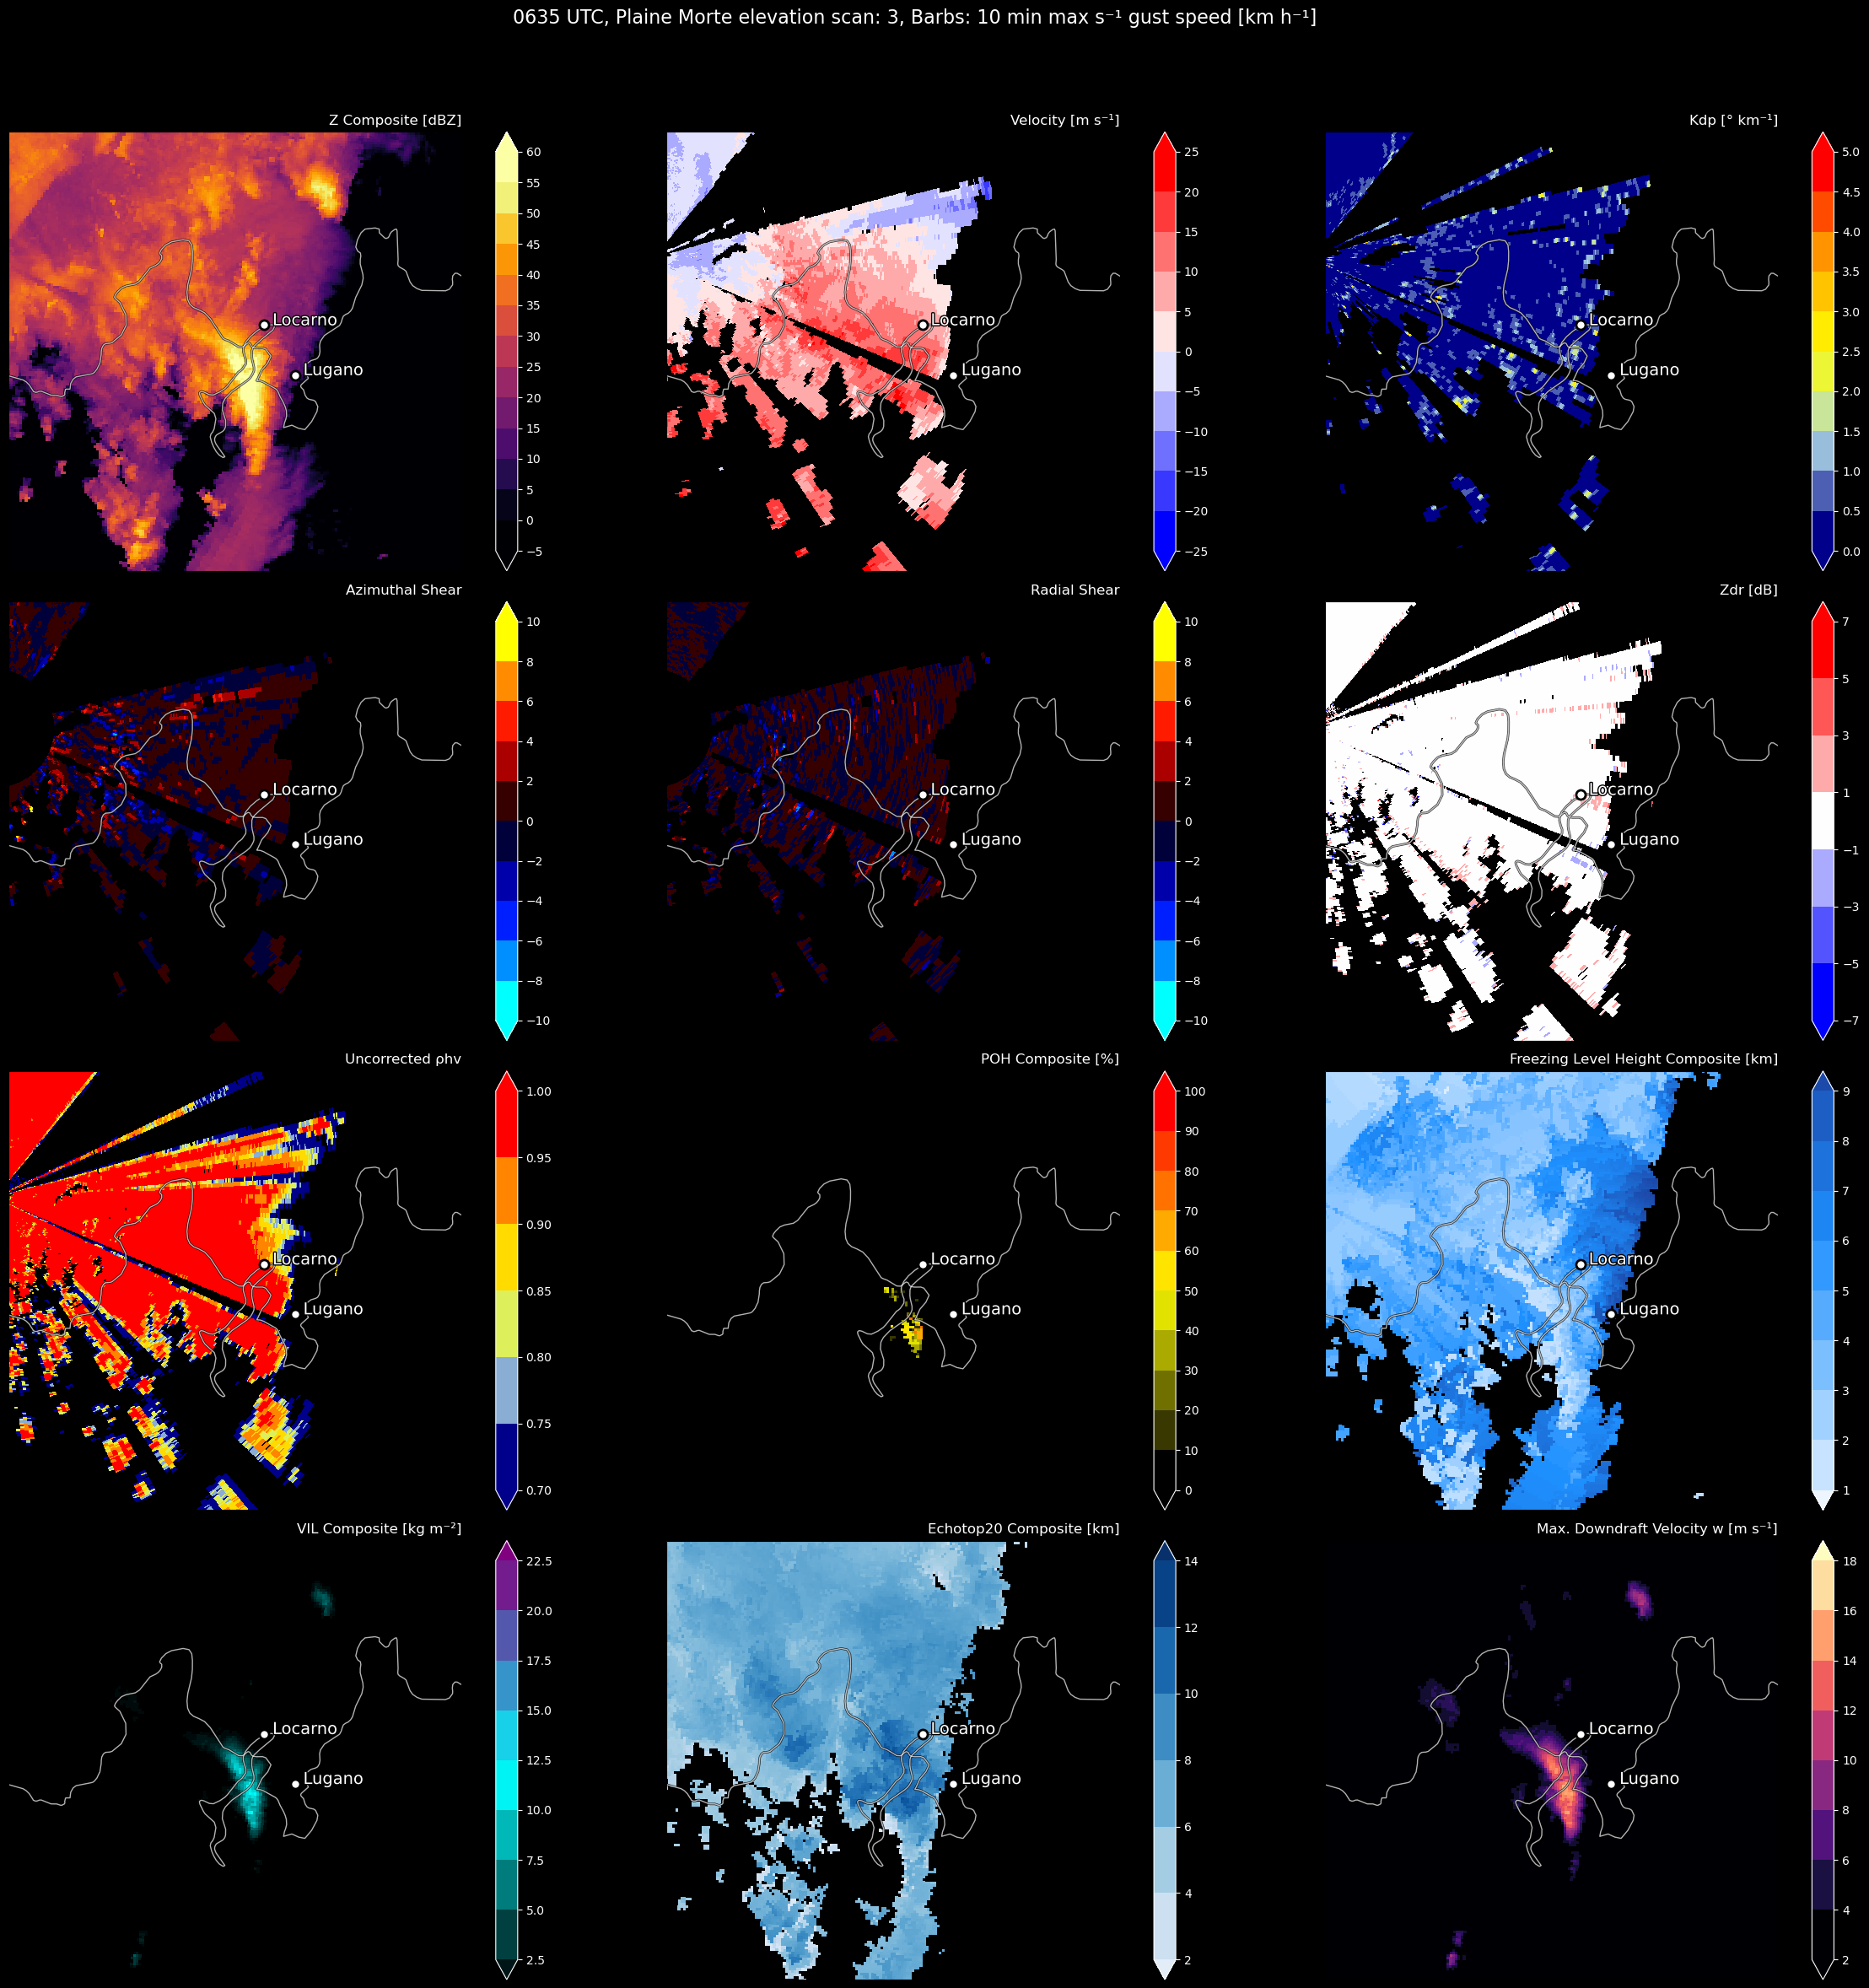

In [56]:
# Multi-variable plot
projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24, 24), subplot_kw={'projection': projection})

# Set background to black for all subplots
for row in axs:  # axs is a 2D array, so iterate through rows
    for ax in row:  # Iterate through each subplot in the row
        fig.patch.set_facecolor('black')  # Set figure background
        ax.set_facecolor('black')  # Set axis background


# Plot Reflectivity composite
cmap_czc.set_bad(color='grey')
p1 = axs[0,0].pcolormesh(clons, clats, czc, vmin=0, vmax=55, 
                   cmap=cmap_czc, transform=projection)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=axs[0,0], extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor('white')
cbar1.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')
axs[0,0].set_title('Z Composite [dBZ]', color='white', loc='right')


# Plot Dealiased Velocity
cmap_velocity.set_bad(color='black')
p2 = axs[0,1].pcolormesh(lons, lats, dv_velocity, cmap=cmap_velocity, norm=velocity_norm, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(p2, ax=axs[0,1], cmap=cmap_velocity, extend='both', boundaries=velocity_levels, ticks=velocity_levels)
cbar2.outline.set_edgecolor('white')
cbar2.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')
axs[0,1].set_title('Velocity [m s⁻¹]', color='white', loc='right')


# Plot Radial shear
#cmap_specw.set_bad(color='black')
p9 = axs[1,1].pcolormesh(lons, lats, llsd_vel[1], cmap=cmap_div_shear, norm=div_shear_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[1,1], cmap=cmap_div_shear, extend='both', boundaries=div_shear_levels, ticks=div_shear_levels
                     )
cbar9.outline.set_edgecolor('white')
cbar9.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color='white')
axs[1,1].set_title('Radial Shear', color='white', loc='right')

# Plot Azmiutal shear
#cmap_specw.set_bad(color='black')
p9 = axs[1,0].pcolormesh(lons, lats, llsd_vel[0], cmap=cmap_az_shear, norm=az_shear_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[1,0], cmap=cmap_az_shear, extend='both', boundaries=az_shear_levels, ticks=az_shear_levels
                     )
cbar9.outline.set_edgecolor('white')
cbar9.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color='white')
axs[1,0].set_title('Azimuthal Shear', color='white', loc='right')


# Plot Freezing level height
# Mask values of freezing level height that are 0 or lower
hzc_masked = np.ma.masked_less_equal(hzc, 0)
# Define a custom colormap, setting the under value (for masked/low values) to black
#cmap_hzc.set_under('black')  # Black for values 0 or lower
cmap_hzc.set_bad(color='black')  # Black for invalid data
# Plot the freezing level height with the masked values
p3 = axs[2,2].pcolormesh(clons, clats, hzc_masked, vmin=0, vmax=12, 
                         cmap=cmap_hzc, transform=projection)
# Add a colorbar
cbar3 = plt.colorbar(p3, ax=axs[2,2], extend='both', cmap=cmap_hzc, boundaries=hzc_levels, ticks=hzc_levels)
cbar3.outline.set_edgecolor('white')
cbar3.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar3.ax.axes, 'yticklabels'), color='white')
axs[2,2].set_title('Freezing Level Height Composite [km]', color='white', loc='right')


# Plot Differential Reflectivity
cmap_diff_reflectivity.set_bad(color='black')
p4 = axs[1,2].pcolormesh(lons, lats, diff_reflectivity, cmap=cmap_diff_reflectivity, norm=diff_reflectivity_norm, 
                         transform=ccrs.PlateCarree())
cbar4 = plt.colorbar(p4, ax=axs[1,2], cmap=cmap_diff_reflectivity, extend='both', boundaries=diff_reflectivity_levels, ticks=diff_reflectivity_levels
                     )
cbar4.outline.set_edgecolor('white')
cbar4.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar4.ax.axes, 'yticklabels'), color='white')
axs[1,2].set_title('Zdr [dB]', color='white', loc='right')


# Plot CC ratio
cmap_cc_ratio.set_bad(color='black')
p6 = axs[2,0].pcolormesh(lons, lats, cc_ratio, cmap=cmap_cc_ratio, norm=cc_ratio_norm, 
                         transform=ccrs.PlateCarree())
cbar6 = plt.colorbar(p6, ax=axs[2,0], cmap=cmap_cc_ratio, extend='both', boundaries=cc_ratio_levels, ticks=cc_ratio_levels
                     )
cbar6.outline.set_edgecolor('white')
cbar6.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar6.ax.axes, 'yticklabels'), color='white')
axs[2,0].set_title('Uncorrected ρhv', color='white', loc='right')


# Plot Kdp
cmap_Kdp.set_bad(color='black')
p7 = axs[0,2].pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=axs[0,2], extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor('white')
cbar7.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color='white')
axs[0,2].set_title('Kdp [° km⁻¹]', color='white', loc='right')


# Plot POH
cmap_bzc.set_bad(color='black')
p8 = axs[2,1].pcolormesh(clons, clats, bzc, norm=bzc_norm,
                   cmap=cmap_bzc, transform=projection)
# Add a colorbar
cbar8 = plt.colorbar(p8, ax=axs[2,1], extend='both', cmap=cmap_bzc, boundaries=bzc_levels, ticks=bzc_levels
                     )
cbar8.outline.set_edgecolor('white')
cbar8.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar8.ax.axes, 'yticklabels'), color='white')
axs[2,1].set_title('POH Composite [%]', color='white', loc='right')


# Plot VIL composite
#lzc = np.ma.masked_less_equal(lzc, 0.1)
cmap_lzc.set_bad(color='black')
p10 = axs[3,0].pcolormesh(clons, clats, lzc, vmin=1, vmax=22.5, 
                   cmap=cmap_lzc, transform=projection)
# Add a colorbar
cbar10 = plt.colorbar(p10, ax=axs[3,0], extend='both', cmap=cmap_lzc, norm=lzc_norm, boundaries=lzc_levels, ticks=lzc_levels
                     )
cbar10.outline.set_edgecolor('white')
cbar10.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar10.ax.axes, 'yticklabels'), color='white')
axs[3,0].set_title('VIL Composite [kg m⁻²]', color='white', loc='right')

# Plot Echotop 20 composite
# Set a mask
ezc = np.ma.masked_less_equal(ezc, 0)
cmap_ezc.set_bad(color='black')
p11 = axs[3,1].pcolormesh(clons, clats, ezc, vmin=0, vmax=14, 
                   cmap=cmap_ezc, transform=projection)
# Add a colorbar
cbar11 = plt.colorbar(p11, ax=axs[3,1], extend='both', cmap=cmap_ezc, norm=ezc_norm, boundaries=ezc_levels, ticks=ezc_levels
                     )
cbar11.outline.set_edgecolor('white')
cbar11.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar11.ax.axes, 'yticklabels'), color='white')
axs[3,1].set_title('Echotop20 Composite [km]', color='white', loc='right')

# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge.set_bad(color='black')
p12 = axs[3,2].pcolormesh(clons, clats, wge, vmax=18, 
                   cmap=cmap_wge, transform=projection)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=axs[3,2], extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor('white')
cbar12.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color='white')
axs[3,2].set_title('Max. Downdraft Velocity w [m s⁻¹]', color='white', loc='right')

# (Plotting of wind barbs and other features remains the same)
for row in axs:
    for ax in row:
            #ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree())  # Radar location
        ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
        ax.plot(locarno_lon, locarno_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())  # Geneva
        ax.plot(lugano_lon, lugano_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())  # Lausanne
        ax.set_extent([7.6, 9.75 , 45.35, 46.8], crs=ccrs.PlateCarree())
         # Add borders, coastlines, and lakes with custom contour lines
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        # Add city names with a black outline for visibility
        locarno_text = ax.text(locarno_lon + 0.04, locarno_lat, 'Locarno', color='white', fontsize=14, transform=ccrs.PlateCarree())
        lugano_text = ax.text(lugano_lon + 0.04, lugano_lat, 'Lugano', color='white', fontsize=14, transform=ccrs.PlateCarree())
        locarno_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
        lugano_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])




# Data import, assimilation
file_path = '/scratch/mch/fackerma/orders/case_130721/stations/20210713.csv'

# Open the file and read its contents
with open(file_path, 'r') as file:
    station_data = file.readlines()  # Read all lines into a list

# Import stations readme
file_path = '/users/fackerma/newproject1/stations_readme.csv'

# Open and read the file as plain text
try:
    with open(file_path, 'r') as stations:
        stations = stations.readlines()  # Read all lines into a list
    #for line in content[:10]:  # Print the first 10 lines for inspection
        #print(line.strip())
except Exception as e:
    print(f"Error reading file: {e}")

# Parse the station metadata to create a dictionary mapping station ID to coordinates and altitude
station_info = {}

# Extract the relevant station data from 'stations' (first 158 rows)
for line in stations[0:0+158]:  # Starts from line 5, inclusive
    parts = line.strip().split("\t")
    station_id = parts[0].strip()  # First column: Station ID
    
    # Extract coordinates (last column)
    coordinates = parts[-1].strip()  
    x, y = map(int, coordinates.split("/"))  # Split the coordinates into x and y

    # Extract altitude (using regex to find the number before "m a.s.l.")
    altitude_match = re.search(r'(\d+)\s*m\s*a\.s\.l\.', parts[1])
    altitude = int(altitude_match.group(1)) if altitude_match else None  # Default to None if no altitude found
    
    station_info[station_id] = (x, y, altitude)

# Add Swiss coordinates and altitude to 'station_data'
updated_station_data = []

# Add headers for clarity
header = station_data[0].strip() + "   X_COORD   Y_COORD   ALTITUDE\n"
updated_station_data.append(header)

for line in station_data[1:]:  # Skip the header
    parts = line.strip().split()
    station_id = parts[0].strip()  # First column: Station ID
    
    # Lookup coordinates and altitude for the station
    x, y, altitude = station_info.get(station_id, (None, None, None))
    
    if x is not None and y is not None and altitude is not None:
        # Append the coordinates and altitude as new columns
        updated_line = line.strip() + f"   {x}   {y}   {altitude}\n"
    else:
        # In case no coordinates or altitude are found (unlikely here), keep it unchanged
        updated_line = line.strip() + "   N/A   N/A   N/A\n"
    
    updated_station_data.append(updated_line)

# Assuming converter.LV03toWGS84() function is defined, and it converts LV03 to WGS84
# Function to convert LV03 to WGS84 (assuming this is already defined)
# Example: converter.LV03toWGS84(x, y, altitude) returns [latitude, longitude, altitude]

# Iterate over each row in updated_station_data (skip the header)
for i, line in enumerate(updated_station_data[1:], start=1):
    parts = line.strip().split()
    
    # Extract the X_COORD, Y_COORD, and ALTITUDE for the current station
    x_coord = int(parts[-3])  # X_COORD is the second last column
    y_coord = int(parts[-2])  # Y_COORD is the last column before altitude
    altitude = int(parts[-1])  # ALTITUDE is the last column in the row
    
    # Convert LV03 (x_coord, y_coord, altitude) to WGS84 (latitude, longitude, altitude)
    wgs84 = converter.LV03toWGS84(x_coord, y_coord, altitude)
    
    # Append the WGS84 values as new columns: latitude, longitude, altitude
    updated_station_data[i] = line.strip() + f"   {wgs84[0]}   {wgs84[1]}   {wgs84[2]}"
    
# Add headers for latitude, longitude, and altitude to the header row
header = updated_station_data[0].strip() + "   LATITUDE   LONGITUDE   ALTITUDE_NEW"
updated_station_data[0] = header

# Data assimilation
# Extract the headers and rows
headers = updated_station_data[0].split()
data = [line.split() for line in updated_station_data[1:]]

# Create a DataFrame
df = pd.DataFrame(data, columns=headers)

# Convert relevant columns to numeric (e.g., the wind gust column '101')
df['101'] = pd.to_numeric(df['101'], errors='coerce')
df['197'] = pd.to_numeric(df['197'], errors='coerce')
df['UTC'] = (df['JAHR'].astype(str) +
                      df['MO'].astype(str).str.zfill(2) +
                      df['TG'].astype(str).str.zfill(2) +
                      df['HH'].astype(str).str.zfill(2) +
                      df['MM'].astype(str).str.zfill(2))

# Filter the data for the timestamp closest to 14:30 UTC (1430)
target_time = '20210713' + valid_time3
filtered_df = df[df['UTC'] == target_time]
# Filter out rows where the '101' value is greater than 200
filtered_df = filtered_df[filtered_df['101'] <= 200]

# Extract necessary columns (station ID, wind speed, wind direction)
wind_speeds = filtered_df['101'].values
wind_directions = filtered_df['197'].values
station_ids = filtered_df['STA'].values

filtered_df['LONGITUDE'] = pd.to_numeric(filtered_df['LONGITUDE'], errors='coerce')
filtered_df['LATITUDE'] = pd.to_numeric(filtered_df['LATITUDE'], errors='coerce')
filtered_df['101'] = pd.to_numeric(filtered_df['101'], errors='coerce')
filtered_df['197'] = pd.to_numeric(filtered_df['197'], errors='coerce')

# Drop rows with invalid data
filtered_df = filtered_df.dropna(subset=['LONGITUDE', 'LATITUDE', '101', '197'])


# Select a specific subplot for the wind barbs (e.g., the first subplot)
#ax = axs[0:3, 0:2]  # Adjust the index based on your layout preference

# Iterate over rows in the filtered dataframe
for _, row in filtered_df.iterrows():
    try:
        # Extract values directly without wrapping them in float or np.array
        longitude = row['LONGITUDE']
        latitude = row['LATITUDE']
        speed = row['101']  # Wind speed
        direction = row['197']  # Wind direction

        # Ensure the values are 1-dimensional arrays
        longitude = np.array([longitude])  # Wrap as 1D array
        latitude = np.array([latitude])    # Wrap as 1D array
        speed = np.array([speed])
        direction = np.array([direction])
        
        # Convert to wind components
        u = -speed * np.sin(np.radians(direction)) * 3.6
        v = -speed * np.cos(np.radians(direction)) * 3.6
        
        for row in axs:
            for ax in row:
        # Add a single wind barb
                ax.barbs(longitude, latitude, u, v, transform=ccrs.PlateCarree(), color='black', length=6, linewidth=1.5)
                ax.barbs(longitude, latitude, u, v, transform=ccrs.PlateCarree(), color='lime', length=6, linewidth=1)
    except ValueError as e:
        print(f"Skipping row due to error: {e}")


# Set main title
plt.suptitle(valid_time3 + ' UTC, ' + radar_name +' elevation scan: ' + elevation_scan + ', Barbs: 10 min max s⁻¹ gust speed [km h⁻¹]', color='white', fontsize=16, x=0.5)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
plt.savefig("/users/fackerma/newproject1/figures/second_case/" + radar_station + valid_time3 + "_" + elevation_scan + "_all_variables.png", facecolor='black', dpi=300)

In [6]:
# Daily POH

projection = ccrs.epsg(3035)
# Create figure with one subplot (dBZC composite)
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw={'projection': projection})

# Set background to black for the plot
fig.patch.set_facecolor('black')  # Set the overall figure background
ax.set_facecolor('black')  # Set axis background

# Plot dBZC composite
dBZC = np.ma.masked_less_equal(dBZC, 0)
cmap_dBZC = cmap_bzc
cmap_dBZC.set_bad(color='black')
p2 = ax.pcolormesh(clons, clats, dBZC, cmap=cmap_dBZC, transform=projection, vmin=0, vmax=100)

# Add a colorbar for the plot, capping it between 0 and 100
cbar2 = plt.colorbar(p2, ax=ax, extend='neither', cmap=cmap_dBZC, boundaries=np.linspace(0, 100, 11), ticks=np.linspace(0, 100, 11))
cbar2.outline.set_edgecolor('white')
cbar2.ax.yaxis.set_tick_params(color='white', labelsize=14)
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')
ax.set_title('POH [%]', color='white', loc='right', fontsize=14)

# Add Radar, Geneva, and Lausanne locations to the plot
# ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree(),
#         path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
# ax.plot(geneva_lon, geneva_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())
# ax.plot(lausanne_lon, lausanne_lat, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree())
ax.set_extent([5, 11, 44.7, 48], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7#, transform=ccrs.PlateCarree()
               )
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7#, transform=ccrs.PlateCarree()
               )
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7#, transform=ccrs.PlateCarree()
               )
ax.gridlines(alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure (adjust this line to your desired path)
#plt.savefig("/users/fackerma/newproject1/figures/second_case/dailyPOH_2.png", facecolor='black', dpi=300)




## RHI

[46.17226618847223, 8.787498886080753, 417.17735892]
Azimuth angle to downburst occurrence: 226.82 degrees
Looking for files with time: 0645
Files found for time 0645: ['/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.001', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.002', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.003', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.004', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.005', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.006', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.007', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.008', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.009', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.010', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.011', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406450U.012', '/scratch/mch/fackerma/orde

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/correct/region_dealias.py:389: RuntimeWarning: overflow encountered in cast
  labels.astype('int32'), data.astype('float32'),
/tmp/ipykernel_217559/980689103.py:331: RuntimeWarning: overflow encountered in multiply
  + u_k_thet * ( - np.sum(weights * d_r * d_r) * np.sum(weights) + np.sum(weights * d_r) * np.sum(weights * d_r)) \
/tmp/ipykernel_217559/980689103.py:367: RuntimeWarning: overflow encountered in multiply
  * ( u_k_r * (- np.sum(weights * d_theta * d_theta) * np.sum(weights) + np.sum(weights * d_theta) * np.sum(weights * d_theta)) \
/tmp/ipykernel_217559/980689103.py:368: RuntimeWarning: invalid value encountered in multiply
  + u_k_thet * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \


Looking for files with time: 0655
Files found for time 0655: ['/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.001', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.002', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.003', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.004', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.005', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.006', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.007', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.008', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.009', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.010', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.011', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.012', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.013', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406550U.014', 

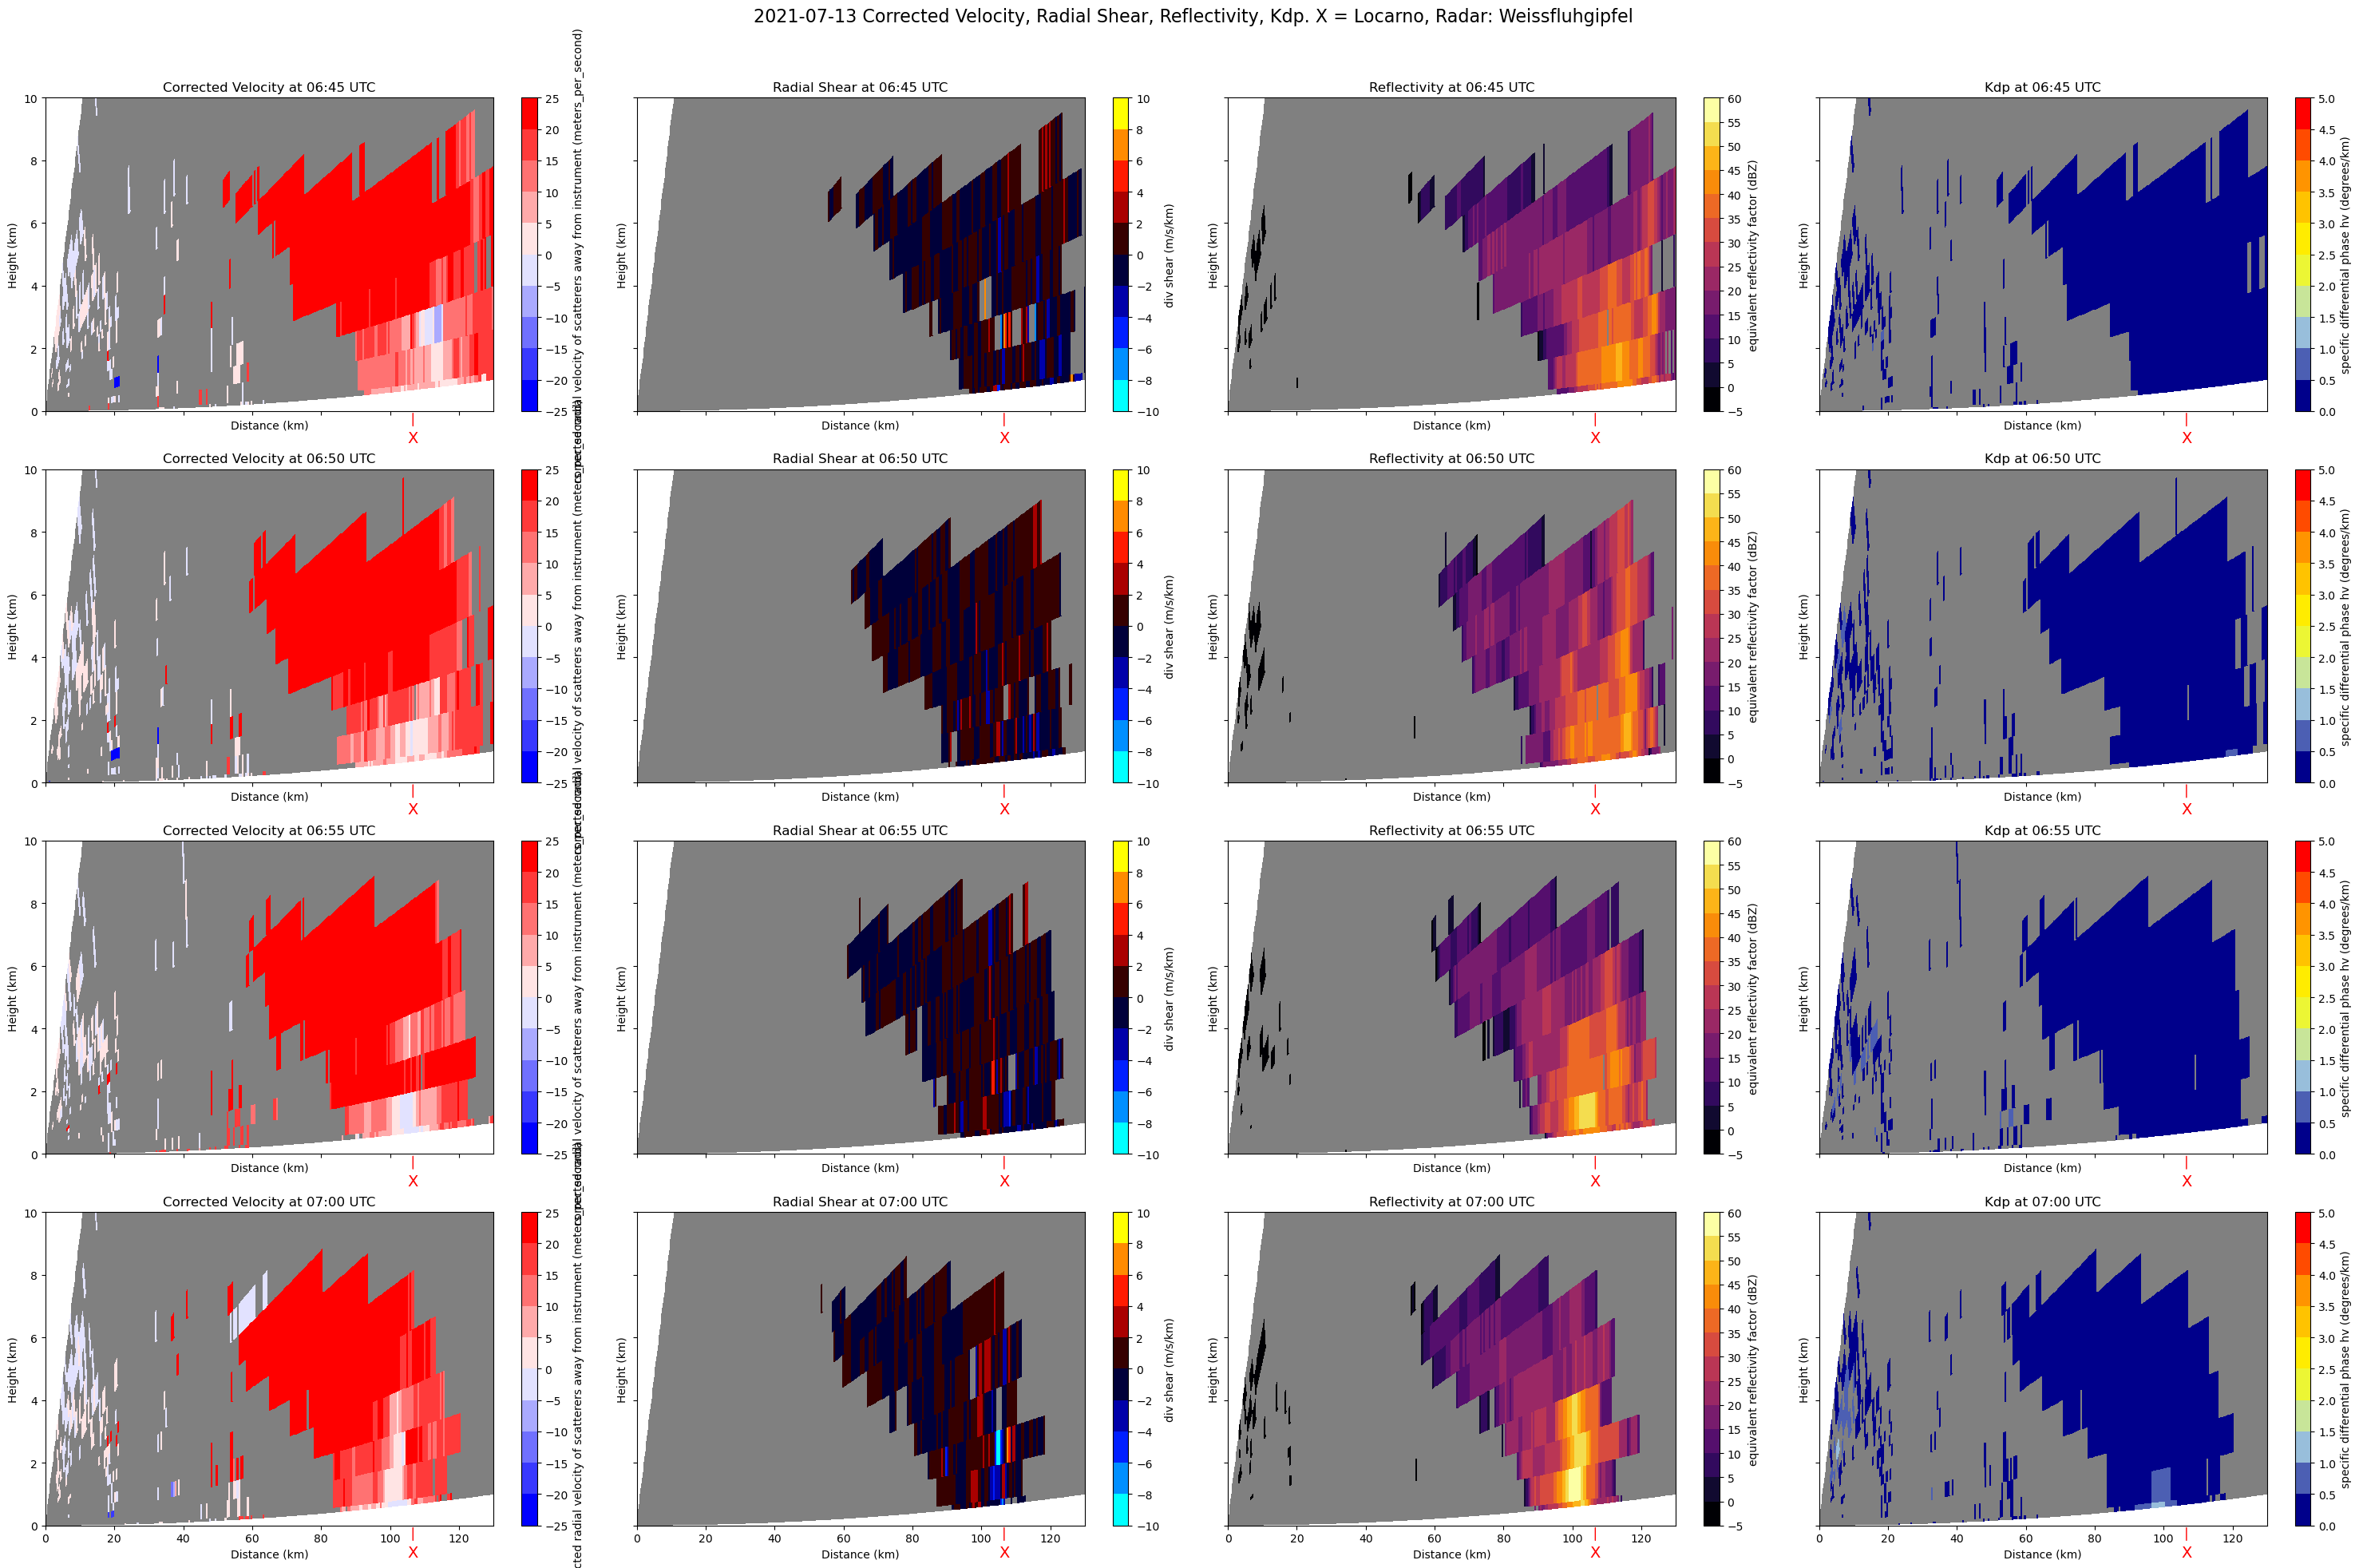

In [4]:
# Downburst location Locarno 0700
downburst_x = 704167
downburst_y = 114317
downburst_z = 367

# Define time intervals: x minutes before, and the exact time
time_deltas = [-15, -10, -5, 0]  # minutes

wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
print(wgs84)
downburst_lat = wgs84[0]
downburst_lon = wgs84[1]

radar_coords = (radar_lat, radar_lon)
downburst_coords = (downburst_lat, downburst_lon)
downburst_distance = geopy.distance.geodesic(radar_coords, downburst_coords).km

# Calculate azimuth
azimuth_to_downburst = calculate_azimuth(radar_lat, radar_lon, downburst_lat, downburst_lon)
print(f"Azimuth angle to downburst occurrence: {azimuth_to_downburst:.2f} degrees")

# Convert valid_time3 to a datetime object
base_time = datetime.strptime(valid_time3, "%H%M")

# Set up the figure with 4 rows and 2 columns
fig, axes = plt.subplots(len(time_deltas), 4, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle("2021-07-13 Corrected Velocity, Radial Shear, Reflectivity, Kdp. X = Locarno, Radar: " + radar_name , fontsize=16)

for row, delta in enumerate(time_deltas):
    # Calculate the time for this row
    current_time = (base_time + timedelta(minutes=delta)).strftime("%H%M")
    print(f"Looking for files with time: {current_time}")
    
    # Check what files are available in the directory
    files_rhi = sorted(glob.glob(f"{path}/MLL/ML{radar_station}21194{current_time}*"))
    print(f"Files found for time {current_time}: {files_rhi}")

    # Proceed only if files are found
    if not files_rhi:
        print(f"No files found for time {current_time}. Skipping.")
        continue

    # Merge radar data for the current time
    for i, f in enumerate(files_rhi):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged = radar
        else:
            radar_merged = pyart.util.join_radar(radar_merged, radar)

    # Perform dealiasing
    corr_vel = pyart.correct.dealias_region_based(radar_merged)
    kdp = pyart.retrieve.kdp_vulpiani(radar_merged, psidp_field='uncorrected_differential_phase', band='C', parallel=True)

    #Add 'Kdp' field if it doesn't already exist
    # Add 'kdp' field if it doesn't already exist, wrapped in a dictionary with the 'data' key
    if 'kdp' not in radar_merged.fields:
        radar_merged.add_field('kdp', kdp[0])
    else:
        print(f"Field 'kdp' already exists for time {current_time}. Skipping addition.")
    
    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged.fields:
        radar_merged.add_field('corrected_velocity', corr_vel)
    else:
        print(f"Field 'corrected_velocity' already exists for time {current_time}. Skipping addition.")


    div_shear = llsd(vel=radar_merged.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=2, r_k=1.5, resolution=0.5)

    # Assuming div_shear is a NumPy array or similar
    div_shear_dict = {
        'data': div_shear[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }

    # Now, add the field to the radar object
    radar_merged.add_field('div_shear', div_shear_dict)


    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi = pyart.util.cross_section_ppi(radar_merged, [azimuth_to_downburst])
    display = pyart.graph.RadarDisplay(pseudorhi)

    # Define axes for corrected velocity (left) and reflectivity (right)
    ax_vel = axes[row, 0]
    ax_ref = axes[row, 2]
    ax_kdp = axes[row, 3]
    ax_div_shear = axes[row, 1] 

    # Plot 'corrected_velocity' with specified color limits
    cmap_velocity.set_bad(color='grey')
    display.plot_rhi('corrected_velocity', ax=ax_vel, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
    ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for velocity
    #cbar = plt.colorbar(display.plots[0], ax=ax_vel)
    #cbar.set_label('[m s⁻¹]', fontsize=12)

    # Plot 'reflectivity'
    cmap_czc.set_bad(color='grey')
    display.plot_rhi('reflectivity', ax=ax_ref, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
    ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for reflectivity
    #cbar = plt.colorbar(display.plots[1], ax=ax_ref)
    #cbar.set_label('[dBZ]', fontsize=12)

    # Plot 'Kdp'
    cmap_Kdp.set_bad(color='grey')
    display.plot_rhi('kdp', ax=ax_kdp, ticks=Kdp_levels, norm=Kdp_norm, cmap=cmap_Kdp)
    ax_kdp.set_title(f"Kdp at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for Kdp
    #cbar = plt.colorbar(display.plots[2], ax=ax_kdp)
    #cbar.set_label('[° km⁻¹]', fontsize=12)

    # Plot 'div_shear'
    cmap_div_shear.set_bad(color='grey')
    display.plot_rhi('div_shear', ax=ax_div_shear, ticks=div_shear_levels, norm=div_shear_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_div_shear)
    ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for divergence shear
    #cbar = plt.colorbar(display.plots[3], ax=ax_div_shear)
    #cbar.set_label('[m s⁻¹ km⁻¹]', fontsize=12)

    # Mark the downburst distance on the x-axis with an 'X'
    for axis in [ax_vel, ax_ref, ax_kdp, ax_div_shear]:
        axis.annotate('X', xy=(downburst_distance, 0), xytext=(downburst_distance, -1),
                      textcoords='data', ha='center', color='red', fontsize=14,
                      arrowprops=dict(arrowstyle='-', color='red'))

    # Set common axis labels and limits
    ax_vel.set_ylim([0, 10])   # Adjust height range as needed
    ax_vel.set_xlim([0, 130])  # Adjust distance range as needed
    for axis in [ax_vel, ax_ref, ax_kdp, ax_div_shear
                 ]:
        axis.set_xlabel('Distance (km)')
        axis.set_ylabel('Height (km)')


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.savefig("/users/fackerma/newproject1/figures/second_case/" + radar_station + "RHI_Locarno_2.png", dpi=300)

#plt.show()


[46.004225802837276, 8.960320421864175, 323.42197383999996]
Azimuth angle to downburst occurrence: 215.14 degrees
Looking for files with time: 0635
Files found for time 0635: ['/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.001', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.002', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.003', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.004', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.005', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.006', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.007', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.008', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.009', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.010', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.011', '/scratch/mch/fackerma/orders/case_130721/MLL/MLW2119406350U.012', '/scratch/mch/facker

Exception ignored in: <built-in method acquire of _thread.lock object at 0x14c6dff6bb00>
Traceback (most recent call last):
  File "/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid = os.fork()
               ^^^^^^^^^
KeyboardInterrupt: 


KeyboardInterrupt: 

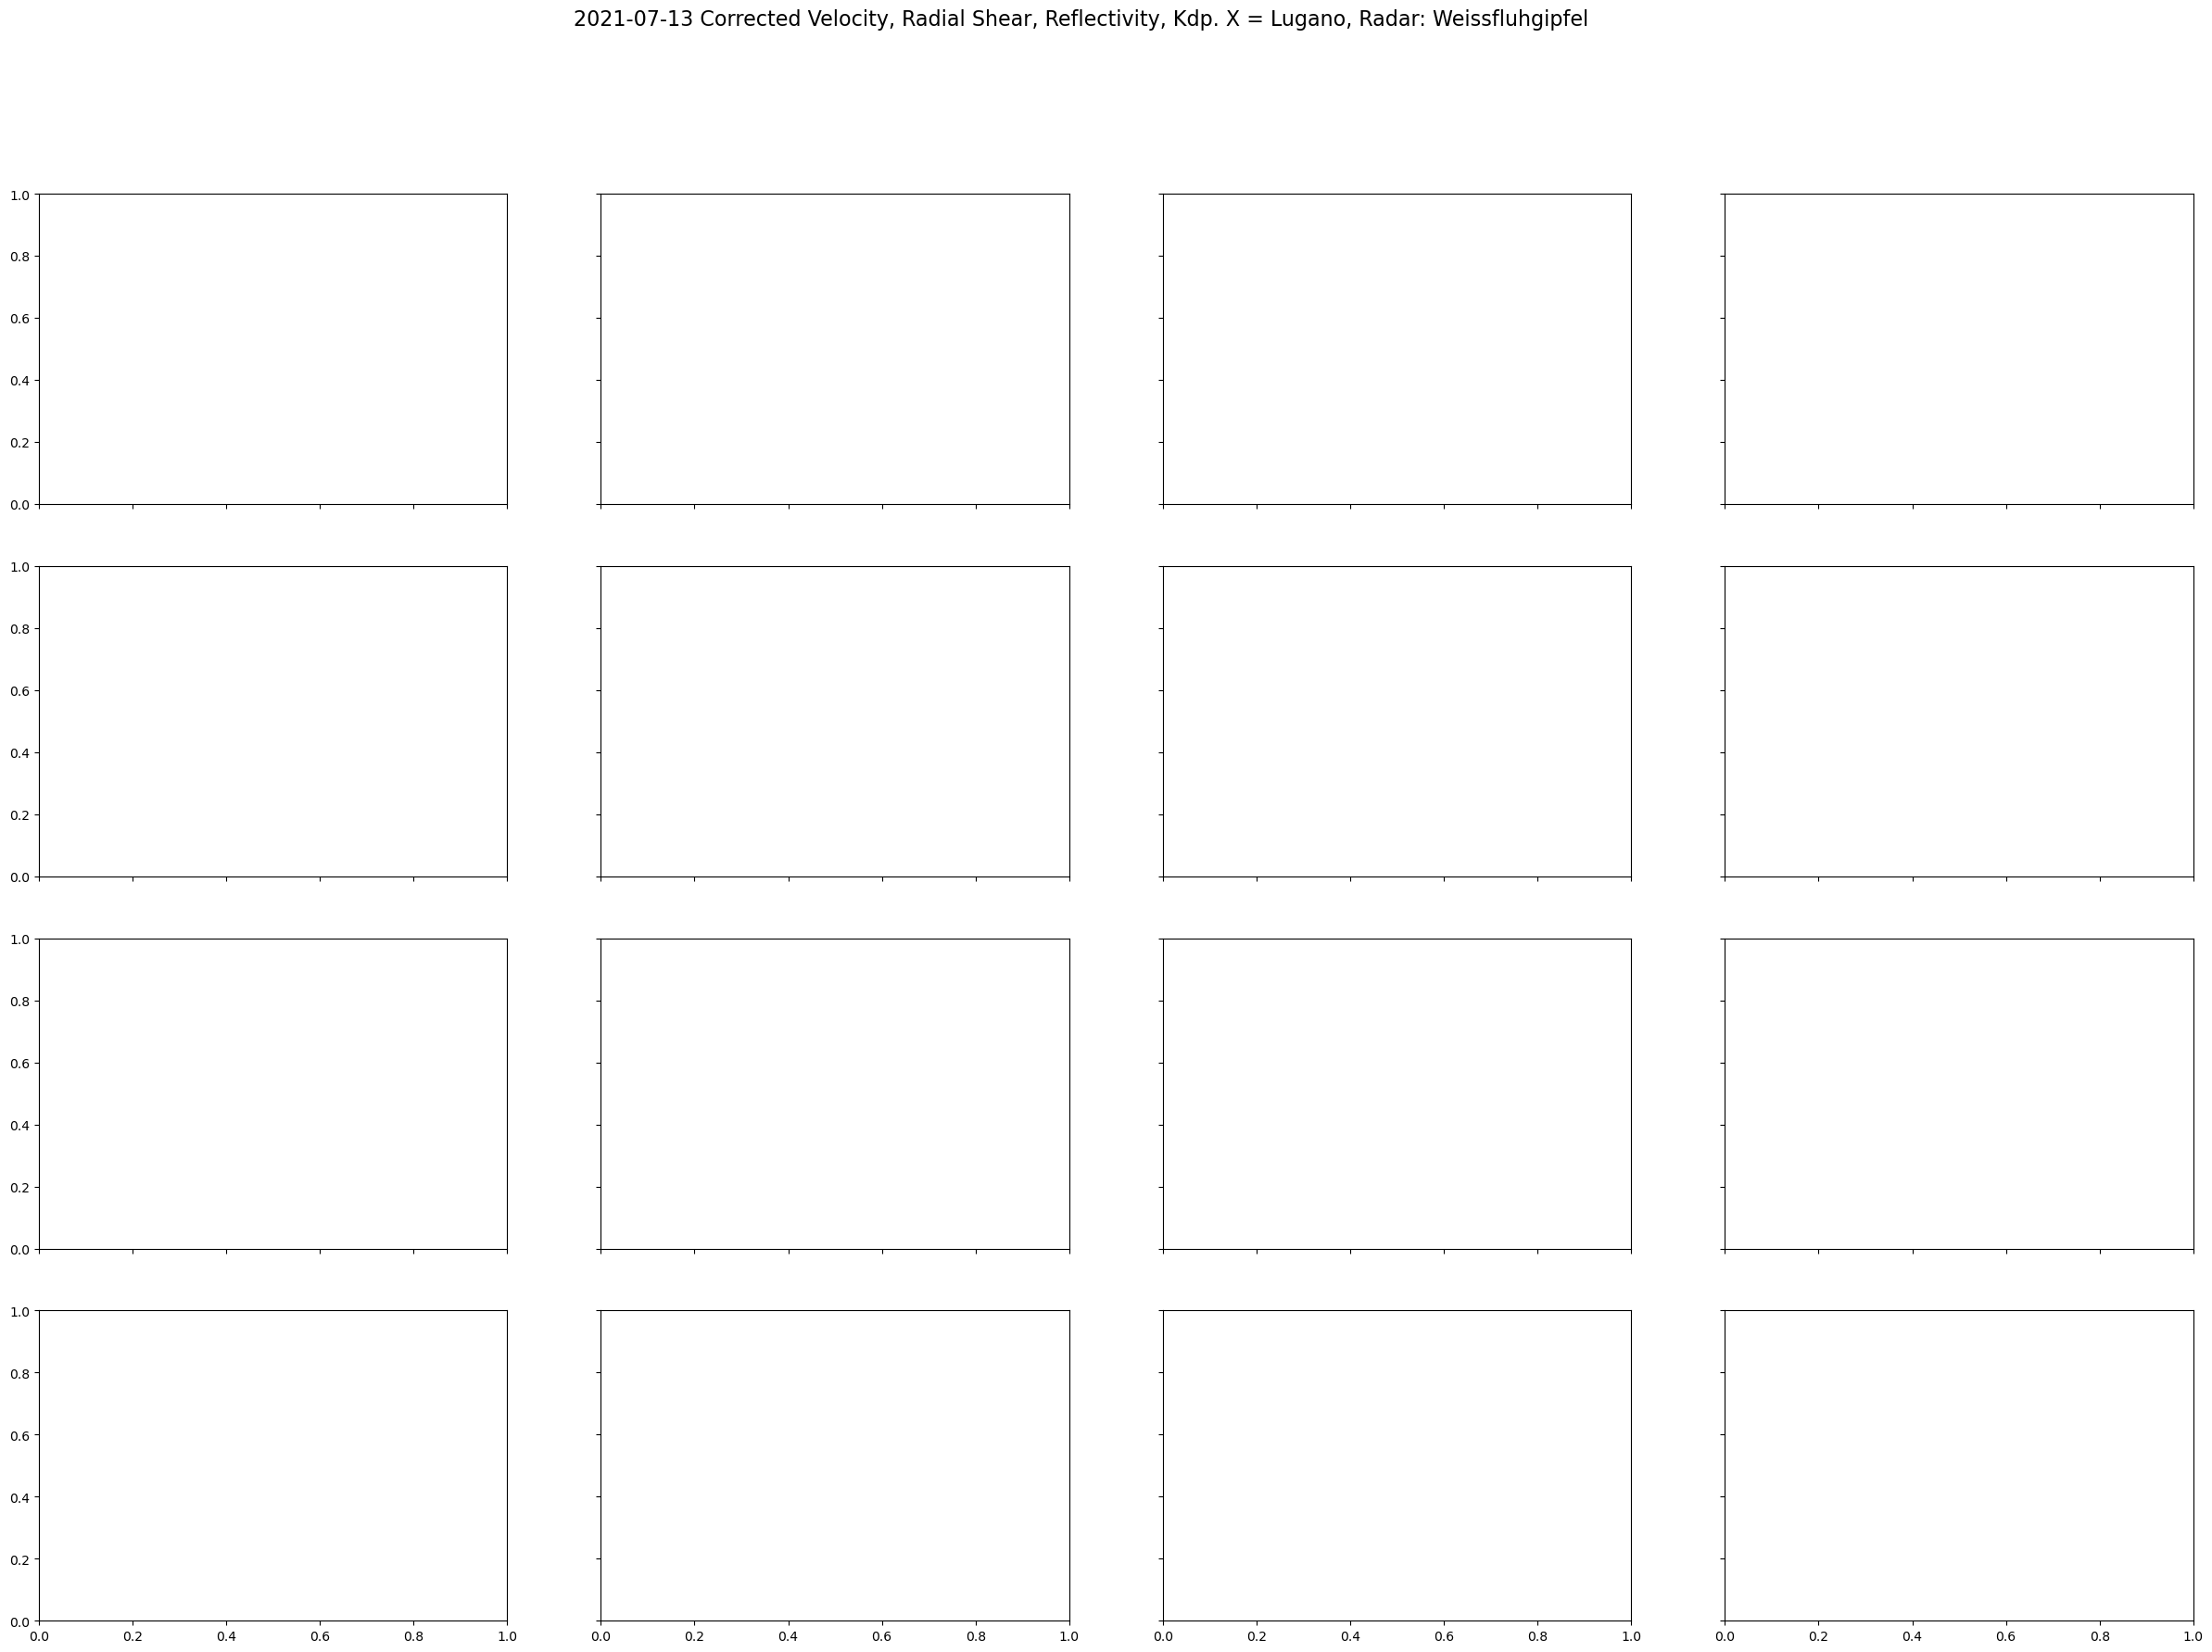

In [8]:

# Downburst location Lugano 0650
downburst_x = 717874
downburst_y = 95884
downburst_z = 273

# Define time intervals: x minutes before, and the exact time
time_deltas = [-15, -10, -5, 0]  # minutes

wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
print(wgs84)
downburst_lat = wgs84[0]
downburst_lon = wgs84[1]

radar_coords = (radar_lat, radar_lon)
downburst_coords = (downburst_lat, downburst_lon)
downburst_distance = geopy.distance.geodesic(radar_coords, downburst_coords).km

# Calculate azimuth
azimuth_to_downburst = calculate_azimuth(radar_lat, radar_lon, downburst_lat, downburst_lon)
print(f"Azimuth angle to downburst occurrence: {azimuth_to_downburst:.2f} degrees")

# Convert valid_time3 to a datetime object
base_time = datetime.strptime(valid_time3, "%H%M")

# Set up the figure with 4 rows and 2 columns
fig, axes = plt.subplots(len(time_deltas), 4, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle("2021-07-13 Corrected Velocity, Radial Shear, Reflectivity, Kdp. X = Lugano, Radar: " + radar_name,  fontsize=16)

for row, delta in enumerate(time_deltas):
    # Calculate the time for this row
    current_time = (base_time + timedelta(minutes=delta)).strftime("%H%M")
    print(f"Looking for files with time: {current_time}")
    
    # Check what files are available in the directory
    files_rhi = sorted(glob.glob(f"{path}/MLL/ML{radar_station}21194{current_time}*"))
    print(f"Files found for time {current_time}: {files_rhi}")

    # Proceed only if files are found
    if not files_rhi:
        print(f"No files found for time {current_time}. Skipping.")
        continue

    # Merge radar data for the current time
    for i, f in enumerate(files_rhi):
        radar = pyart.aux_io.read_metranet(f)
        if i == 0:
            radar_merged = radar
        else:
            radar_merged = pyart.util.join_radar(radar_merged, radar)

    # Perform dealiasing
    corr_vel = pyart.correct.dealias_region_based(radar_merged)
    kdp = pyart.retrieve.kdp_vulpiani(radar_merged, psidp_field='uncorrected_differential_phase', band='C', parallel=True)

    #Add 'Kdp' field if it doesn't already exist
    # Add 'kdp' field if it doesn't already exist, wrapped in a dictionary with the 'data' key
    if 'kdp' not in radar_merged.fields:
        radar_merged.add_field('kdp', kdp[0])
    else:
        print(f"Field 'kdp' already exists for time {current_time}. Skipping addition.")
    
    # Add 'corrected_velocity' field if it doesn't already exist
    if 'corrected_velocity' not in radar_merged.fields:
        radar_merged.add_field('corrected_velocity', corr_vel)
    else:
        print(f"Field 'corrected_velocity' already exists for time {current_time}. Skipping addition.")


    div_shear = llsd(vel=radar_merged.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=2, r_k=1.5, resolution=0.5)

    # Assuming div_shear is a NumPy array or similar
    div_shear_dict = {
        'data': div_shear[1],  # This should be the numerical array
        'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
        'long_name': 'Divergence Shear',  # Add a descriptive name for the field
        'standard_name': 'div_shear',  # You can add any standard name
    }

    # Now, add the field to the radar object
    radar_merged.add_field('div_shear', div_shear_dict)


    # Create a pseudo RHI cross-section at azimuth 270 degrees
    pseudorhi = pyart.util.cross_section_ppi(radar_merged, [azimuth_to_downburst])
    display = pyart.graph.RadarDisplay(pseudorhi)

    # Define axes for corrected velocity (left) and reflectivity (right)
    ax_vel = axes[row, 0]
    ax_ref = axes[row, 2]
    ax_kdp = axes[row, 3]
    ax_div_shear = axes[row, 1] 

    # Plot 'corrected_velocity' with specified color limits
    cmap_velocity.set_bad(color='grey')
    display.plot_rhi('corrected_velocity', ax=ax_vel, vmin=-30, vmax=30, ticks=velocity_levels, norm=velocity_norm, cmap=cmap_velocity)
    ax_vel.set_title(f"Corrected Velocity at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for velocity
    #cbar = plt.colorbar(display.plots[0], ax=ax_vel)
    #cbar.set_label('[m s⁻¹]', fontsize=12)

    # Plot 'reflectivity'
    cmap_czc.set_bad(color='grey')
    display.plot_rhi('reflectivity', ax=ax_ref, ticks=czc_levels, norm=czc_norm, 
                     vmin=-20, vmax=70,
                     cmap=cmap_czc)
    ax_ref.set_title(f"Reflectivity at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for reflectivity
    #cbar = plt.colorbar(display.plots[1], ax=ax_ref)
    #cbar.set_label('[dBZ]', fontsize=12)

    # Plot 'Kdp'
    cmap_Kdp.set_bad(color='grey')
    display.plot_rhi('kdp', ax=ax_kdp, ticks=Kdp_levels, norm=Kdp_norm, cmap=cmap_Kdp)
    ax_kdp.set_title(f"Kdp at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for Kdp
    #cbar = plt.colorbar(display.plots[2], ax=ax_kdp)
    #cbar.set_label('[° km⁻¹]', fontsize=12)

    # Plot 'div_shear'
    cmap_div_shear.set_bad(color='grey')
    display.plot_rhi('div_shear', ax=ax_div_shear, ticks=div_shear_levels, norm=div_shear_norm, 
                     #vmin=-20, vmax=70,
                     cmap=cmap_div_shear)
    ax_div_shear.set_title(f"Radial Shear at {current_time[:2]}:{current_time[2:]} UTC")
    # Customize the colorbar for divergence shear
    #cbar = plt.colorbar(display.plots[3], ax=ax_div_shear)
    #cbar.set_label('[m s⁻¹ km⁻¹]', fontsize=12)

    # Mark the downburst distance on the x-axis with an 'X'
    for axis in [ax_vel, ax_ref, ax_kdp, ax_div_shear]:
        axis.annotate('X', xy=(downburst_distance, 0), xytext=(downburst_distance, -1),
                      textcoords='data', ha='center', color='red', fontsize=14,
                      arrowprops=dict(arrowstyle='-', color='red'))

    # Set common axis labels and limits
    ax_vel.set_ylim([0, 10])   # Adjust height range as needed
    ax_vel.set_xlim([0, 130])  # Adjust distance range as needed
    for axis in [ax_vel, ax_ref, ax_kdp, ax_div_shear
                 ]:
        axis.set_xlabel('Distance (km)')
        axis.set_ylabel('Height (km)')


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
#plt.savefig("/users/fackerma/newproject1/figures/second_case/" + radar_station + "RHI_Lugano_2.png", dpi=300)

#plt.show()


## CAPPI

In [37]:
# Assess CAPPI files
files_rhi = sorted(glob.glob(path + '/MLL/ML' + radar_station + '21194' + valid_time3 + '*')) # Read all elevations for rhi
for i,f in enumerate(files_rhi):
    radar = pyart.aux_io.read_metranet(f)
    
    if i == 0:
        radar_merged = radar
    else:
        radar_merged = pyart.util.join_radar(radar_merged, 
                                       radar)
corr_vel = pyart.correct.dealias_region_based(radar_merged)
radar_merged.add_field('corrected_velocity', corr_vel)


div_shear = llsd(vel=radar_merged.fields['corrected_velocity']['data'], az_min=3, az_max=90, w_k=2, r_k=1.5, resolution=0.5)

# Assuming div_shear is a NumPy array or similar
div_shear_dict = {
    'data': div_shear[1],  # This should be the numerical array
    'units': 'm/s/km',  # You can adjust the units based on the actual meaning of div_shear
    'long_name': 'Divergence Shear',  # Add a descriptive name for the field
    'standard_name': 'div_shear',  # You can add any standard name
}

# Now, add the field to the radar object
radar_merged.add_field('div_shear', div_shear_dict)



/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/correct/region_dealias.py:389: RuntimeWarning: overflow encountered in cast
  labels.astype('int32'), data.astype('float32'),


In [38]:
# Set definitions
zmin = 500
zmax = 8000
ymin= xmin = -100000
ymax = xmax = 100000
lat = float(radar.latitude['data'])
lon = float(radar.longitude['data'])
alt = float(radar.altitude['data'])
# number of grid points in cappi
cappi_res_h = 500
cappi_res_v = 500
ny = int((ymax-ymin)/cappi_res_h)+1
nx = int((xmax-xmin)/cappi_res_h)+1
nz = int((zmax-zmin)/cappi_res_v)+1

cappi_zh = pyart.map.grid_from_radars(radar_merged, grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax),
                     (xmin, xmax)),
        fields=['reflectivity', 'corrected_velocity', 'div_shear'])

display = pyart.graph.GridMapDisplay(cappi_zh)

/tmp/ipykernel_55367/169830237.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat = float(radar.latitude['data'])
/tmp/ipykernel_55367/169830237.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon = float(radar.longitude['data'])
/tmp/ipykernel_55367/169830237.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alt = float(radar.altitude['data'])
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/map/gates_to_grid.py:168: Runt

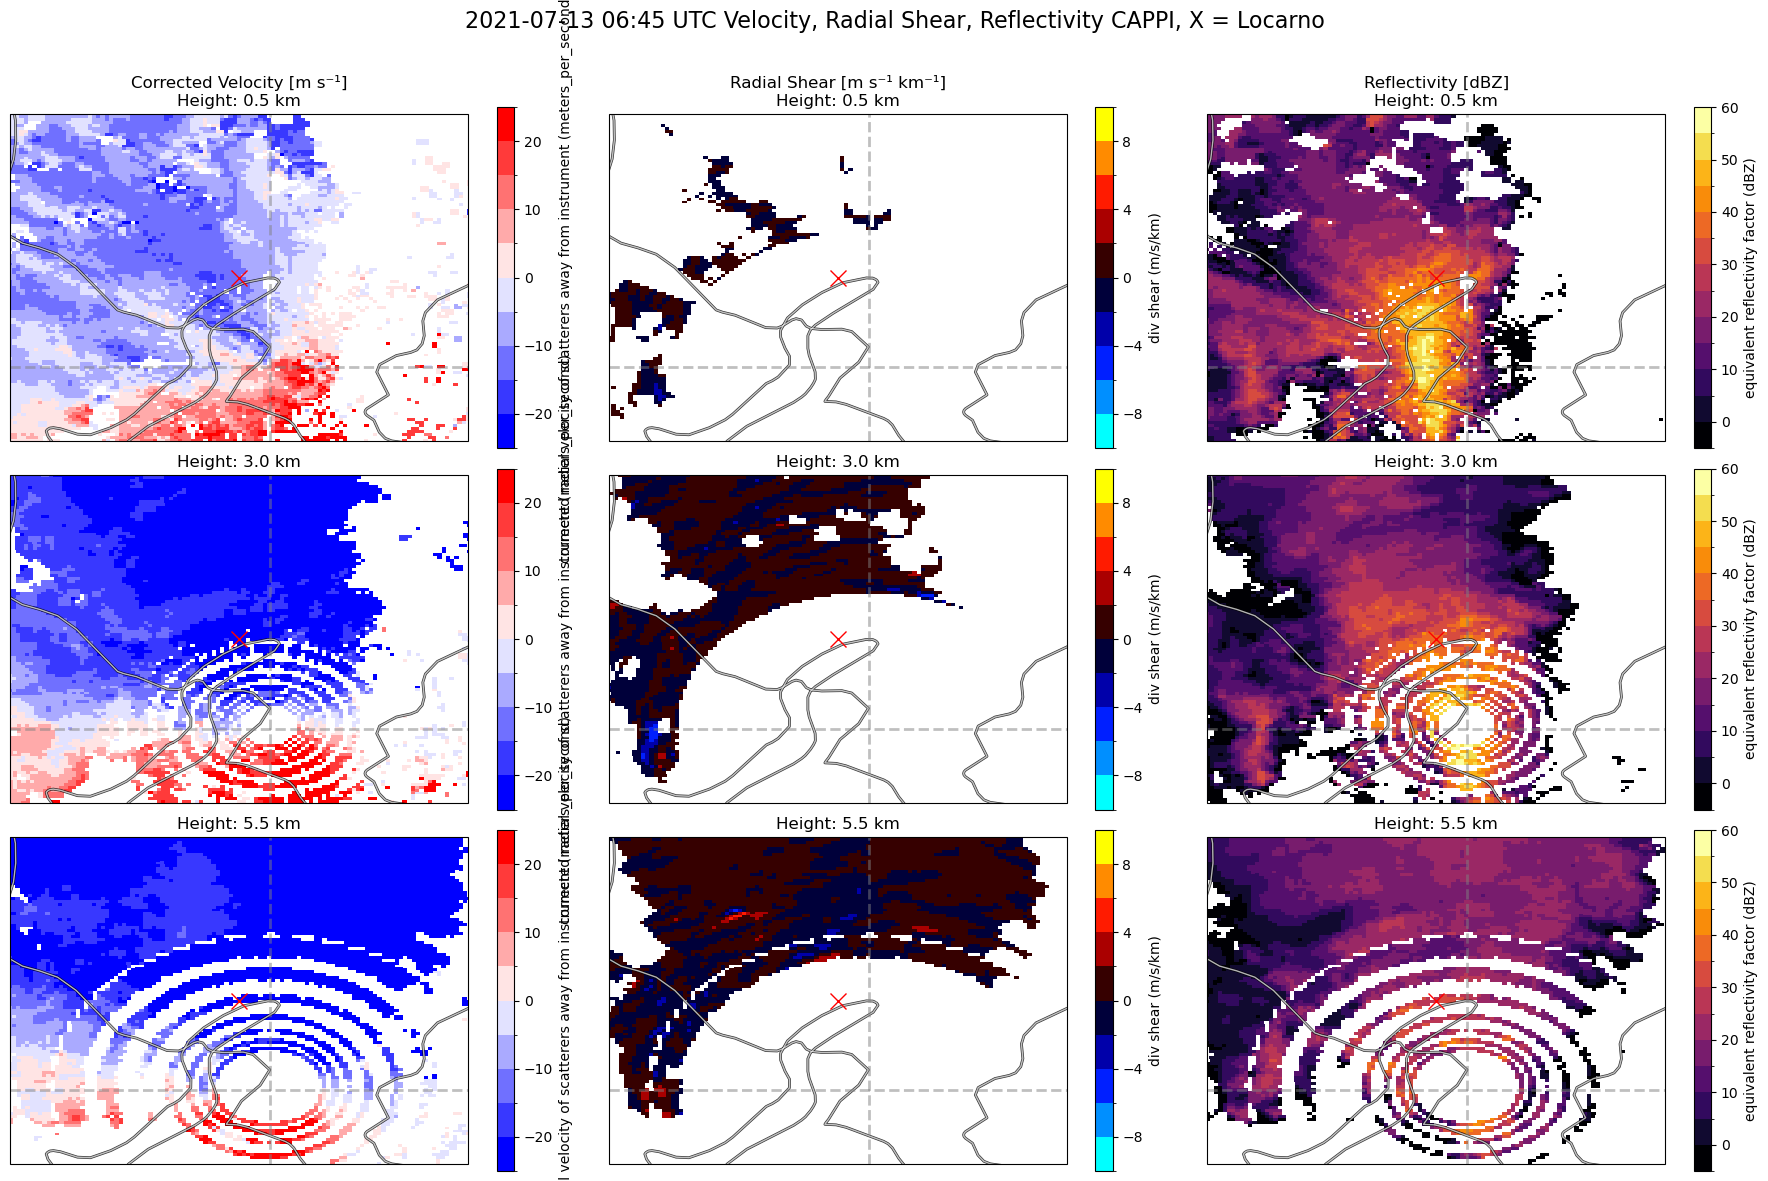

In [ ]:
# Define the projection
projection = ccrs.PlateCarree()

# Downburst location (Swiss grid coordinates) - Locarno: 07:00
downburst_x = 704167
downburst_y = 114317
downburst_z = 367

# Convert Swiss coordinates to WGS84
wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
downburst_lat = wgs84[0]
downburst_lon = wgs84[1]

# Create the figure and subplots
fig = plt.figure(figsize=(18, 12))  # Increase figure height to accommodate three rows

# Define variable configurations: names, colormaps, levels, norms, and titles
variables = [
    ('corrected_velocity', cmap_velocity, velocity_levels, velocity_norm, 'Corrected Velocity [m s⁻¹]'),
    ('div_shear', cmap_div_shear, div_shear_levels, div_shear_norm, 'Radial Shear [m s⁻¹ km⁻¹]'),
    ('reflectivity', cmap_czc, czc_levels, czc_norm, 'Reflectivity [dBZ]')
]

# Define the levels for each row
levels = [0, 5, 10]

# Loop through rows and variables to create subplots
for row_idx, level in enumerate(levels):
    cappi_height = cappi_zh.z['data'][level] / 1000  # Convert height to km
    for col_idx, (var, cmap, levs, norm, title) in enumerate(variables):
        # Calculate subplot index
        subplot_idx = row_idx * len(variables) + col_idx + 1
        
        # Create subplot
        ax = plt.subplot(len(levels), len(variables), subplot_idx, projection=projection)
        
        # Plot the grid data
        display.plot_grid(
            var, level=level, ax=ax, projection=projection,
            cmap=cmap, norm=norm, vmin=levs[0], vmax=levs[-1],
            title=f"{title}\nHeight: {cappi_height:.1f} km" if row_idx == 0 else f"Height: {cappi_height:.1f} km"
        )
        
        # Highlight the downburst location
        ax.plot(downburst_lon, downburst_lat, marker='x', color='red', markersize=12, transform=ccrs.PlateCarree())
        
        # Set the map extent for all plots
        ax.set_extent([ downburst_lon-0.35 , downburst_lon+0.35, downburst_lat+0.25, downburst_lat-0.25], crs=ccrs.PlateCarree())
        
        # Add geographic features
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        
        # Remove axis labels and grid lines
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(linestyle='-', color='black', alpha=0)




fig.suptitle("2021-07-13 06:45 UTC Velocity, Radial Shear, Reflectivity CAPPI, X = Locarno", fontsize=16, ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
#plt.savefig("/users/fackerma/newproject1/figures/second_case/CAPPI_0645_Locarno_1.png", dpi=300)





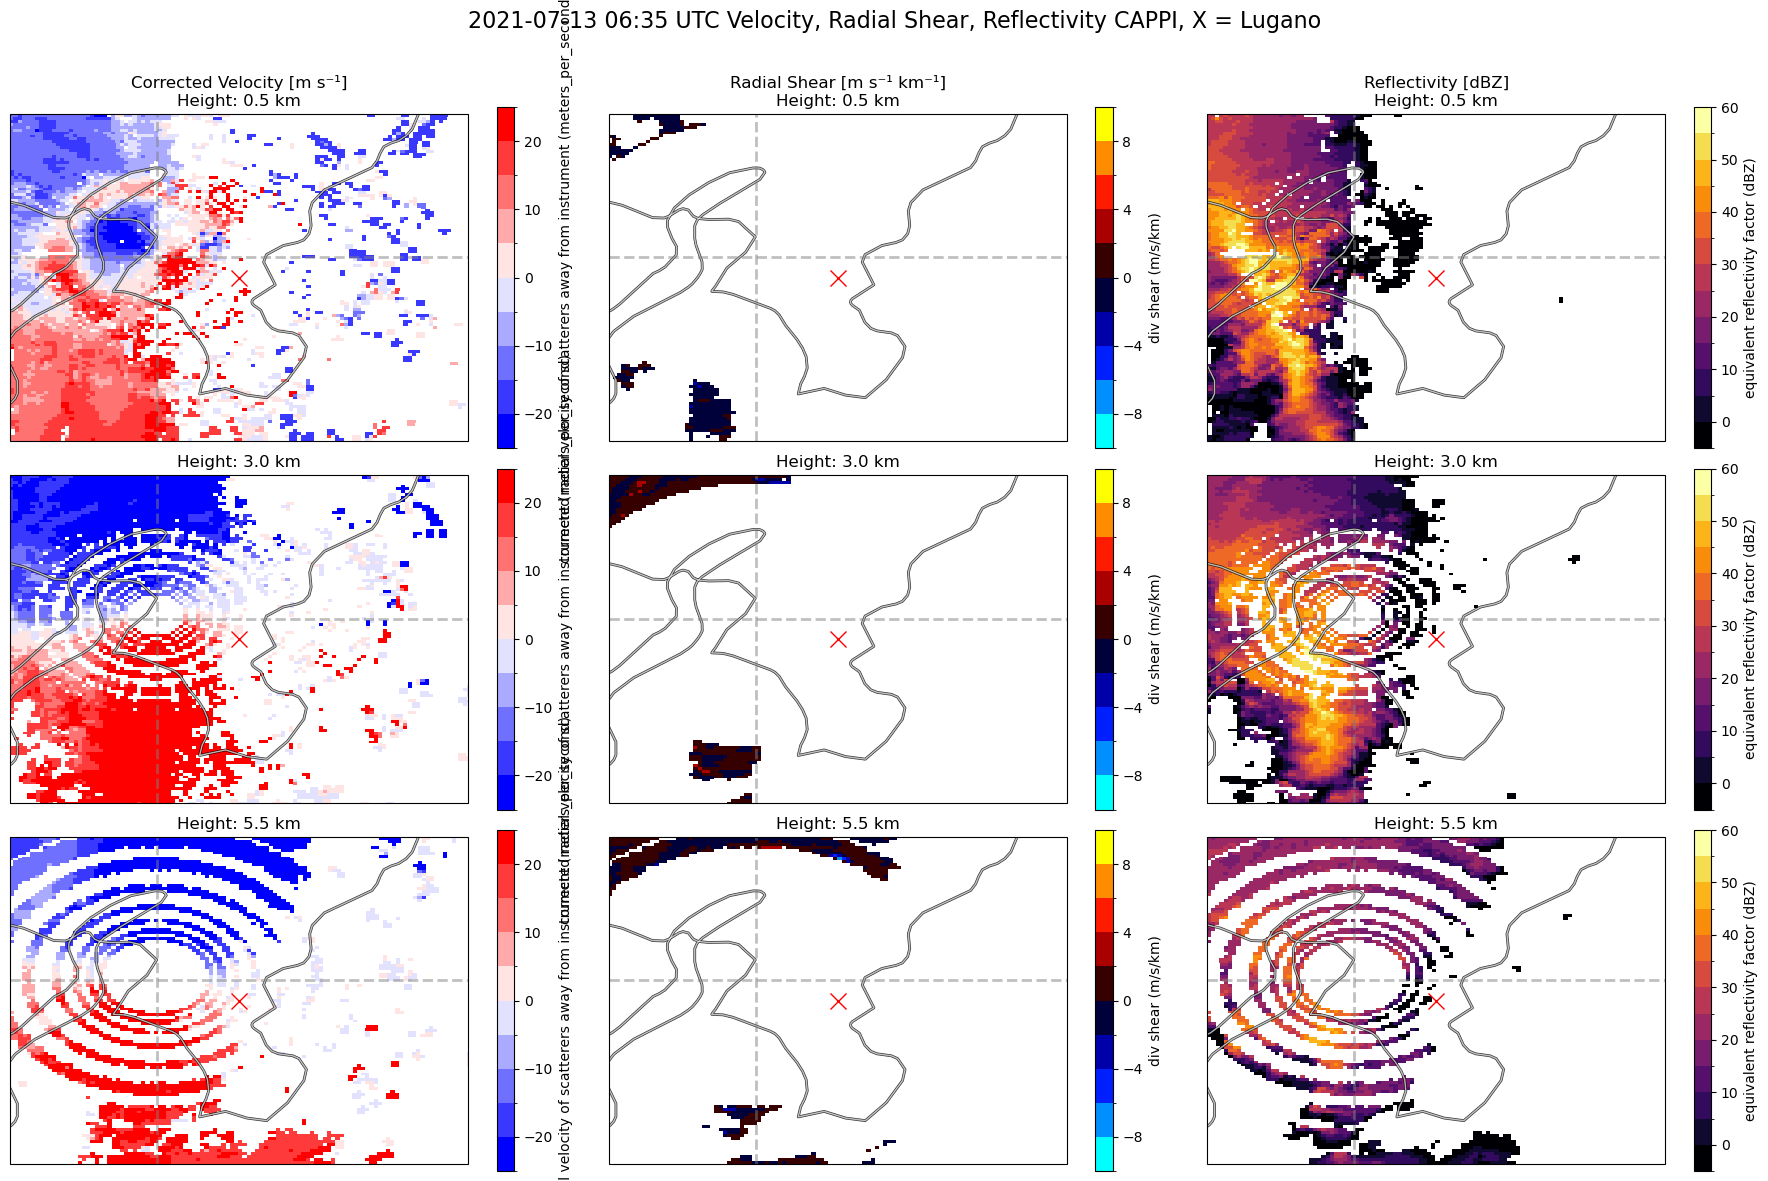

In [ ]:
# Define the projection
projection = ccrs.PlateCarree()

# Downburst location (Swiss grid coordinates) - Lugano: 06:50
downburst_x = 717874
downburst_y = 95884
downburst_z = 273

# Convert Swiss coordinates to WGS84
wgs84 = converter.LV03toWGS84(downburst_x, downburst_y, downburst_z)
downburst_lat = wgs84[0]
downburst_lon = wgs84[1]

# Create the figure and subplots
fig = plt.figure(figsize=(18, 12))  # Increase figure height to accommodate three rows

# Define variable configurations: names, colormaps, levels, norms, and titles
variables = [
    ('corrected_velocity', cmap_velocity, velocity_levels, velocity_norm, 'Corrected Velocity [m s⁻¹]'),
    ('div_shear', cmap_div_shear, div_shear_levels, div_shear_norm, 'Radial Shear [m s⁻¹ km⁻¹]'),
    ('reflectivity', cmap_czc, czc_levels, czc_norm, 'Reflectivity [dBZ]')
]

# Define the levels for each row
levels = [0, 5, 10]

# Loop through rows and variables to create subplots
for row_idx, level in enumerate(levels):
    cappi_height = cappi_zh.z['data'][level] / 1000  # Convert height to km
    for col_idx, (var, cmap, levs, norm, title) in enumerate(variables):
        # Calculate subplot index
        subplot_idx = row_idx * len(variables) + col_idx + 1
        
        # Create subplot
        ax = plt.subplot(len(levels), len(variables), subplot_idx, projection=projection)
        
        # Plot the grid data
        display.plot_grid(
            var, level=level, ax=ax, projection=projection,
            cmap=cmap, norm=norm, vmin=levs[0], vmax=levs[-1],
            title=f"{title}\nHeight: {cappi_height:.1f} km" if row_idx == 0 else f"Height: {cappi_height:.1f} km"
        )
        
        # Highlight the downburst location
        ax.plot(downburst_lon, downburst_lat, marker='x', color='red', markersize=12, transform=ccrs.PlateCarree())
        
        # Set the map extent for all plots
        ax.set_extent([ downburst_lon-0.35 , downburst_lon+0.35, downburst_lat+0.25, downburst_lat-0.25], crs=ccrs.PlateCarree())
        
        # Add geographic features
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        
        # Remove axis labels and grid lines
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(linestyle='-', color='black', alpha=0)




fig.suptitle("2021-07-13 06:35 UTC Velocity, Radial Shear, Reflectivity CAPPI, X = Lugano", fontsize=16, ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
#plt.savefig("/users/fackerma/newproject1/figures/second_case/CAPPI_0635_Lugano_1.png", dpi=300)



